<a href="https://colab.research.google.com/github/Fake-Review-Detection-Spiill-AI/screnario-2---multi-task/blob/main/draft-04-multitask-multilabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library


In [1]:

!pip install Sastrawi
!pip install swifter
!pip install emoji
import pandas as pd
import numpy as np
import re
import emoji
import string
import seaborn as sns
import matplotlib.pyplot as plt
import swifter
from sklearn.utils import resample
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=351dbbbade5d0d2830e35d22cc8726f75cd69a3eac2630d9554476c0c393ee68
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 7.7 MB/s eta 0:00:00


In [2]:
# Loading Essential libraries
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False # this to force autocompletion

# Dataset

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/Fake-Review-Detection-Spiill-AI/screnario-2---multi-task/main/draft02_dataset_review_pribadi.csv',)
df.head()

,username,rate,date,label,sentimen,reviews,produk
0,ziaprlfauzi,4,21-05-2024 03:08 AM,fake,positive,Suka banget pake emina ini dr jaman kuliah sam...,Emina Sunscreen
1,mnisfa,4,20-05-2024 04:13 PM,fake,positive,sunscreen yang ringan banget\r\nengga lengket ...,Emina Sunscreen
2,amandabilla98,4,20-05-2024 07:33 AM,trusted,positive,"sunscreen jaman kuliah, cari nya gampang ada d...",Emina Sunscreen
3,mtraandita,3,19-05-2024 01:36 PM,trusted,neutral,"Waktu smp aku pakai ss ini selama ±2 tahun, te...",Emina Sunscreen
4,Miftahuljahra,2,18-05-2024 06:38 AM,trusted,negative,Aku ga terlalu cocok pake produk ini terlebih ...,Emina Sunscreen


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2394 entries, 0 to 2393
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  2394 non-null   object
 1   rate      2394 non-null   int64 
 2   date      2394 non-null   object
 3   label     2394 non-null   object
 4   sentimen  2394 non-null   object
 5   reviews   2394 non-null   object
 6   produk    2394 non-null   object
dtypes: int64(1), object(6)
memory usage: 131.0+ KB


# EDA

In [5]:
df['text_length'] = df['reviews'].apply(len)
df.text_length.describe()

count    2394.000000
mean      256.362573
std       163.333404
min         1.000000
25%       137.250000
50%       250.000000
75%       319.000000
max      1472.000000
Name: text_length, dtype: float64

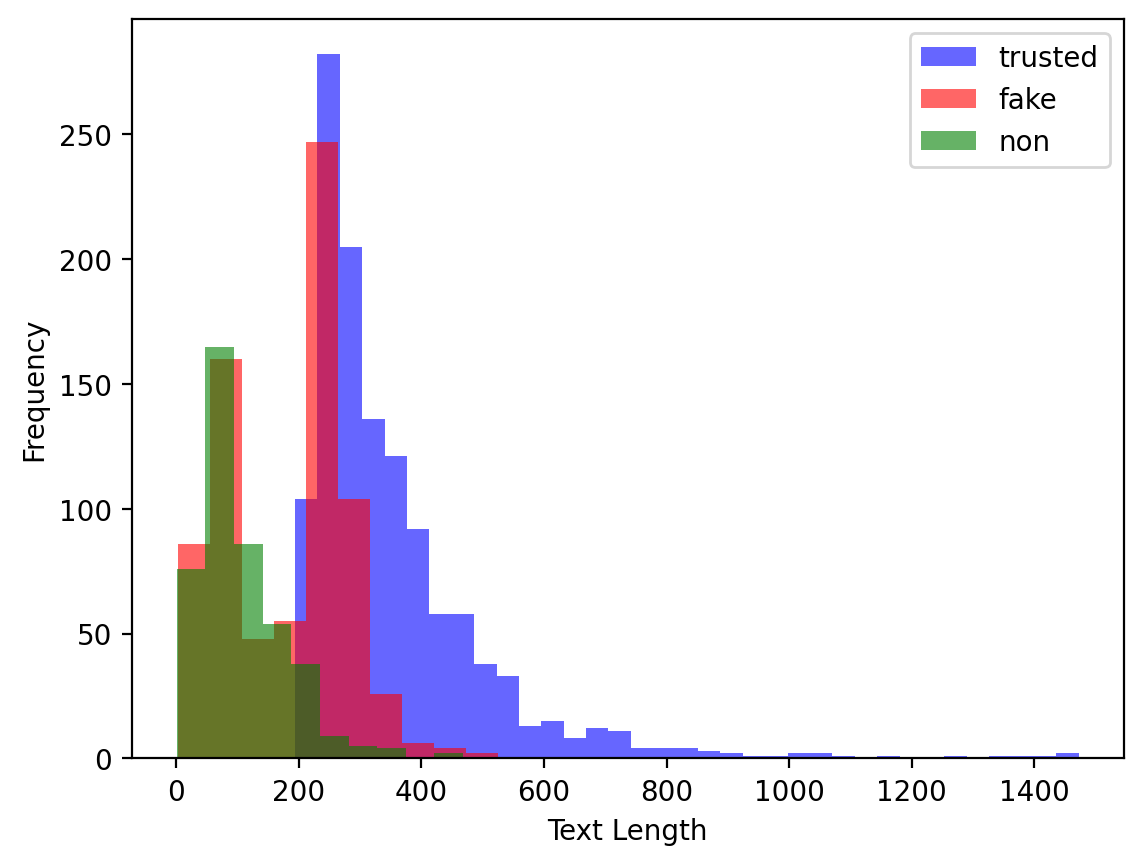

In [6]:
df[df.label=='trusted'].text_length.plot(bins=35, kind='hist', color='blue',
                                       label='trusted', alpha=0.6)
df[df.label == 'fake'].text_length.plot(kind='hist', color='red',
                                       label='fake', alpha=0.6)
df[df.label == 'non'].text_length.plot(kind='hist', color='green',
                                       label='non', alpha=0.6)
plt.legend()
plt.xlabel("Text Length")
plt.show()


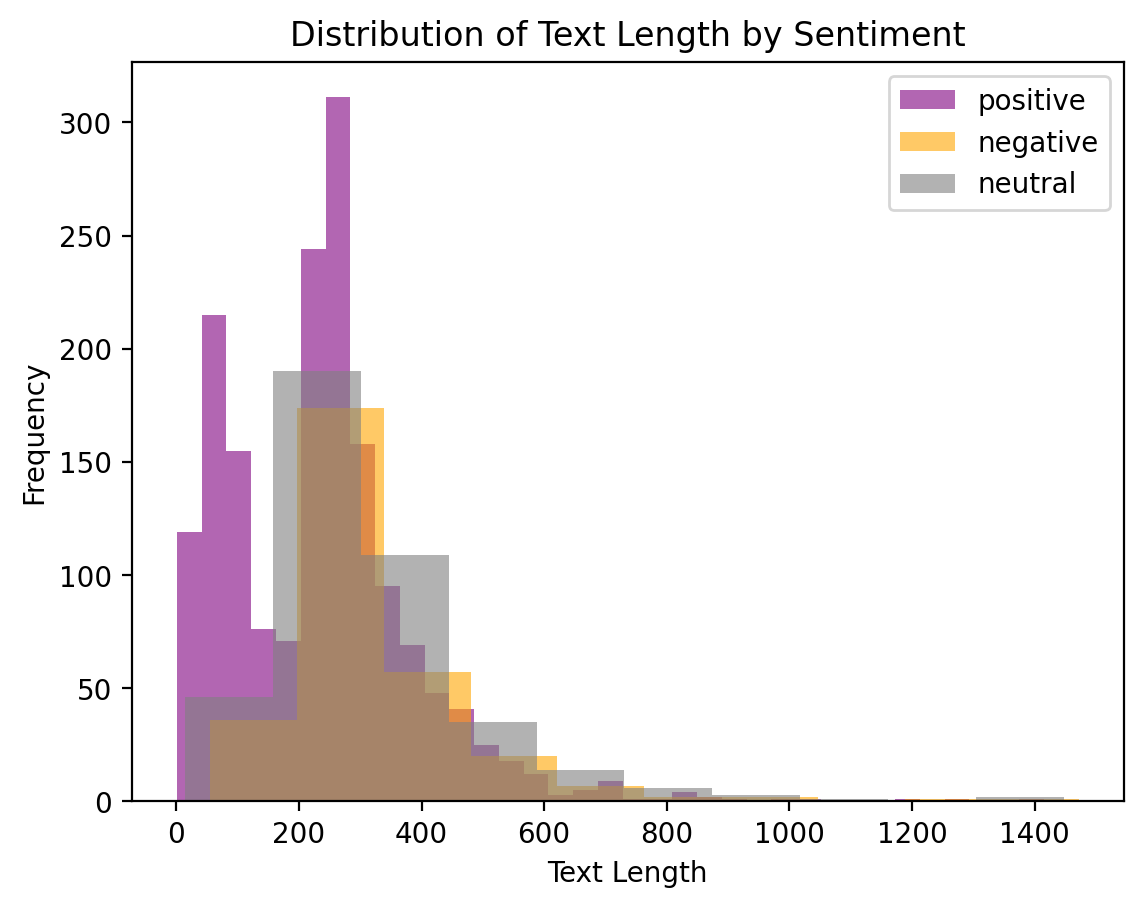

In [7]:
df[df.sentimen == 'positive'].text_length.plot(bins=35, kind='hist', color='purple',
                                               label='positive', alpha=0.6)
df[df.sentimen == 'negative'].text_length.plot(kind='hist', color='orange',
                                               label='negative', alpha=0.6)
df[df.sentimen == 'neutral'].text_length.plot(kind='hist', color='grey',
                                              label='neutral', alpha=0.6)

plt.legend()
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Distribution of Text Length by Sentiment")
plt.show()

In [8]:
df.groupby(['label']).count()

,username,rate,date,sentimen,reviews,produk,text_length
label,,,,,,,
fake,738,738,738,738,738,738,738
non,439,439,439,439,439,439,439
trusted,1217,1217,1217,1217,1217,1217,1217


<Axes: xlabel='label', ylabel='count'>

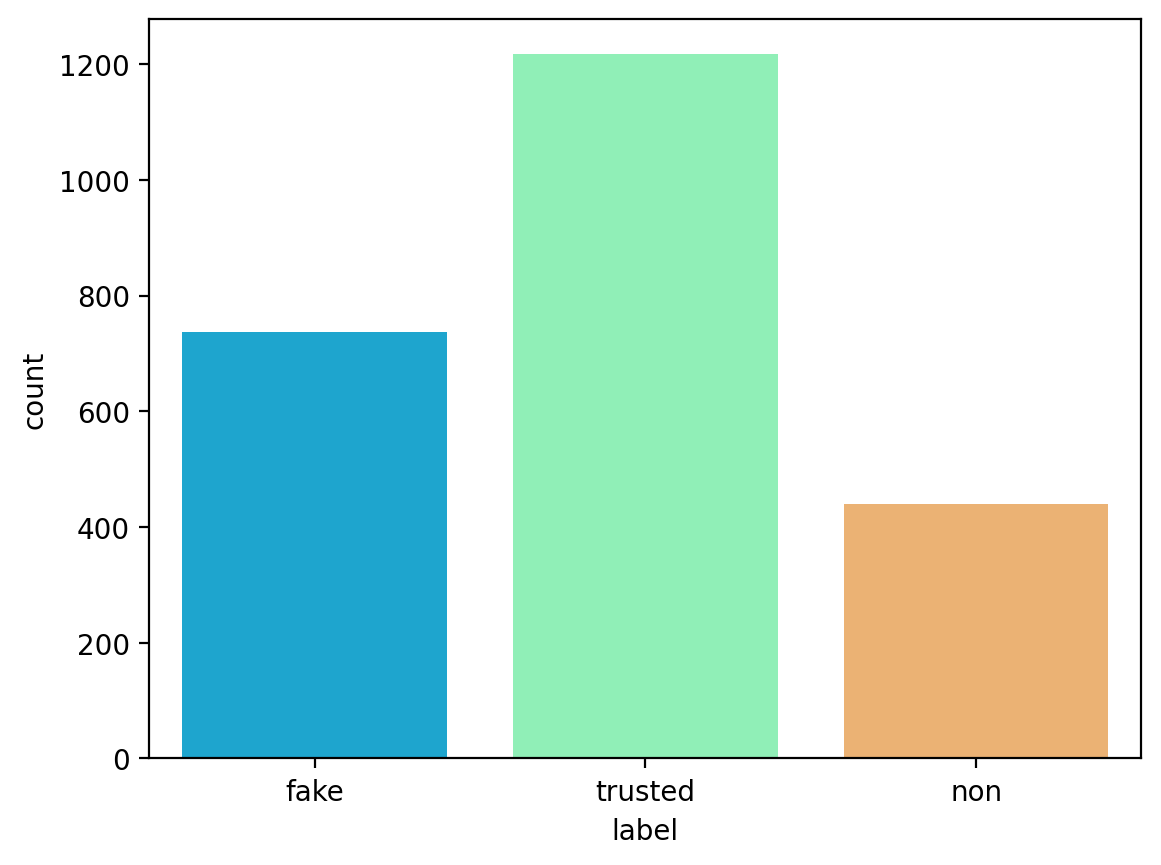

In [9]:
sns.countplot(x='label', data=df, palette='rainbow')

<Axes: xlabel='sentimen', ylabel='count'>

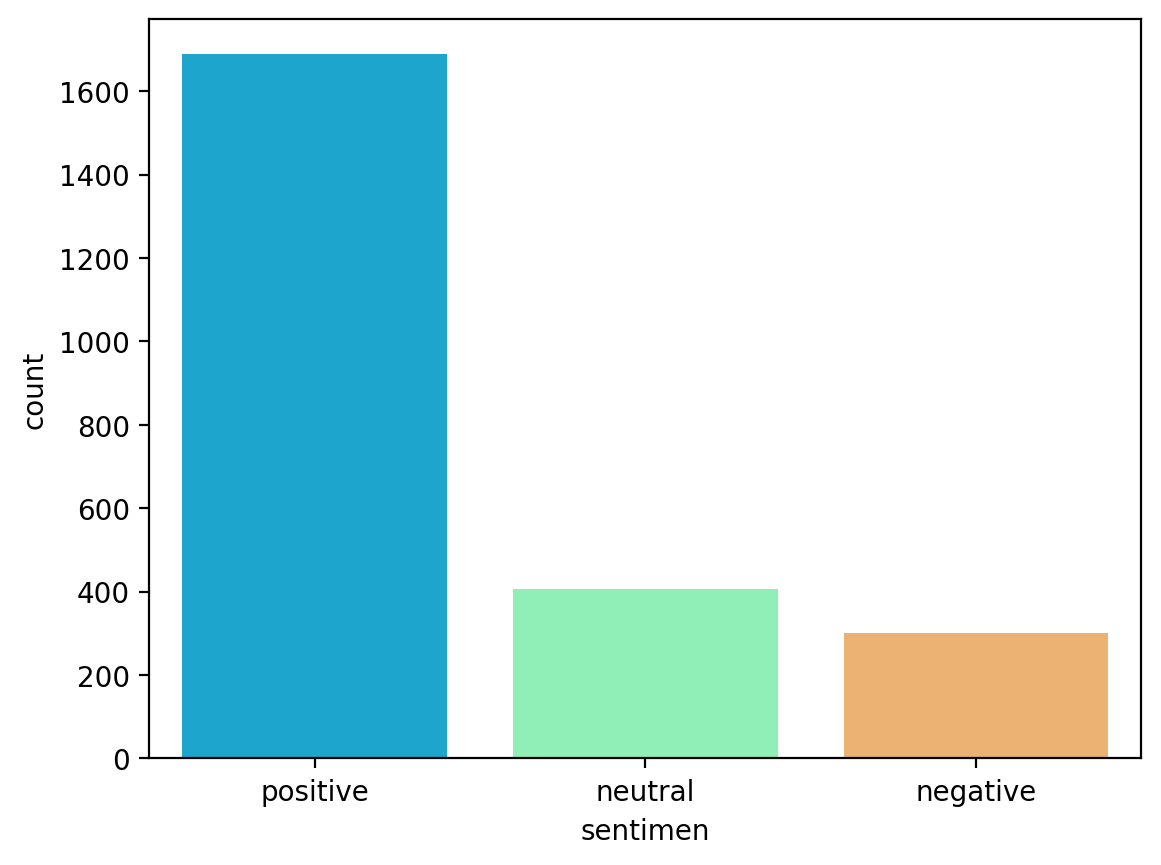

In [10]:
sns.countplot(x='sentimen', data=df, palette='rainbow')

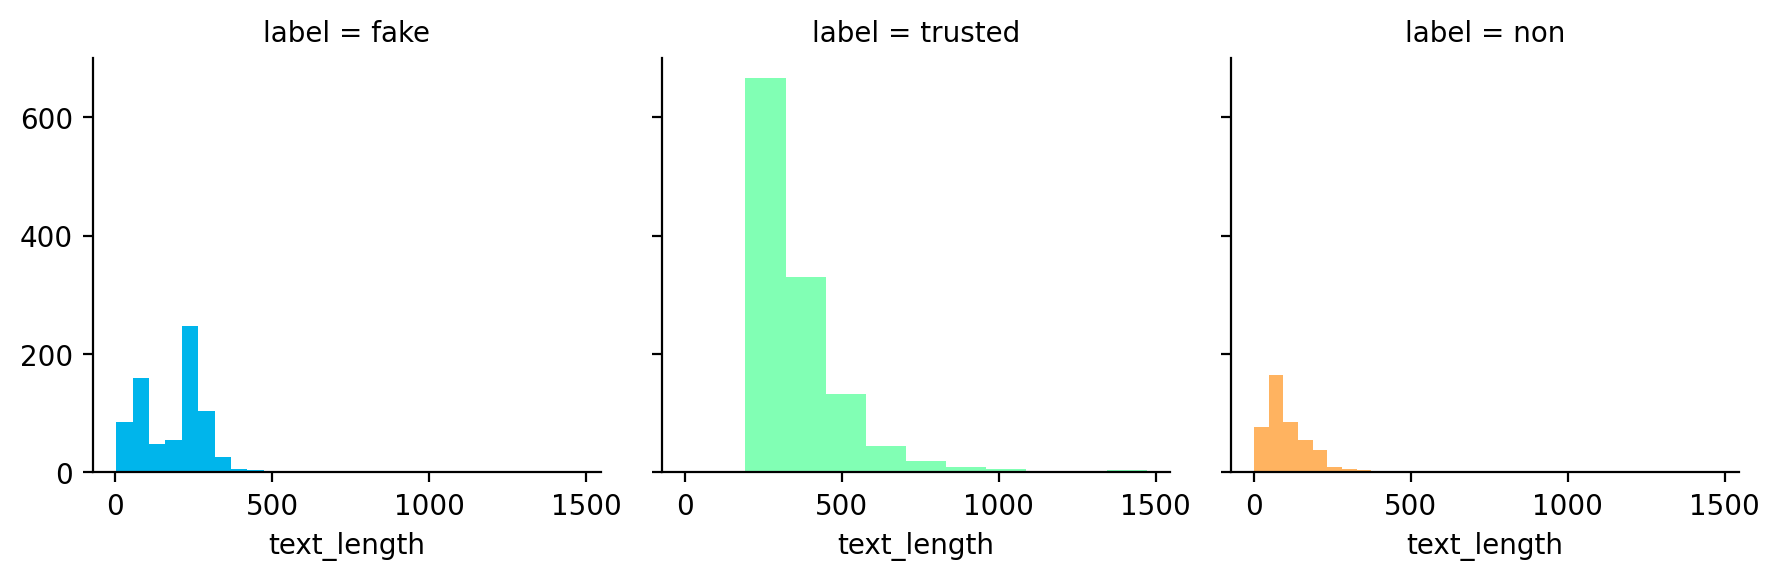

In [11]:
g = sns.FacetGrid(df, col='label', hue='label', palette='rainbow')
g.map(plt.hist, 'text_length')
plt.show()

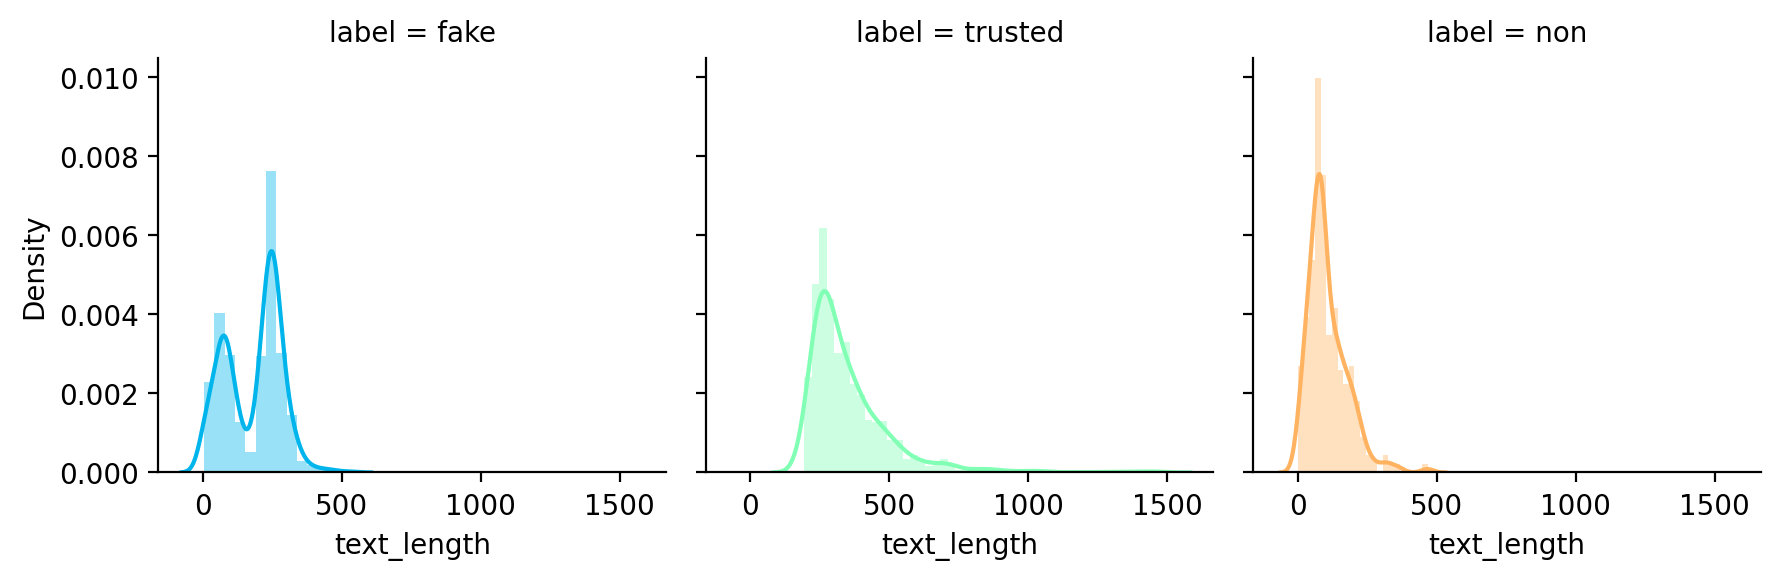

In [12]:
g = sns.FacetGrid(df, col='label', hue='label', palette='rainbow')
g.map(sns.distplot, 'text_length')

<Axes: xlabel='label', ylabel='text_length'>

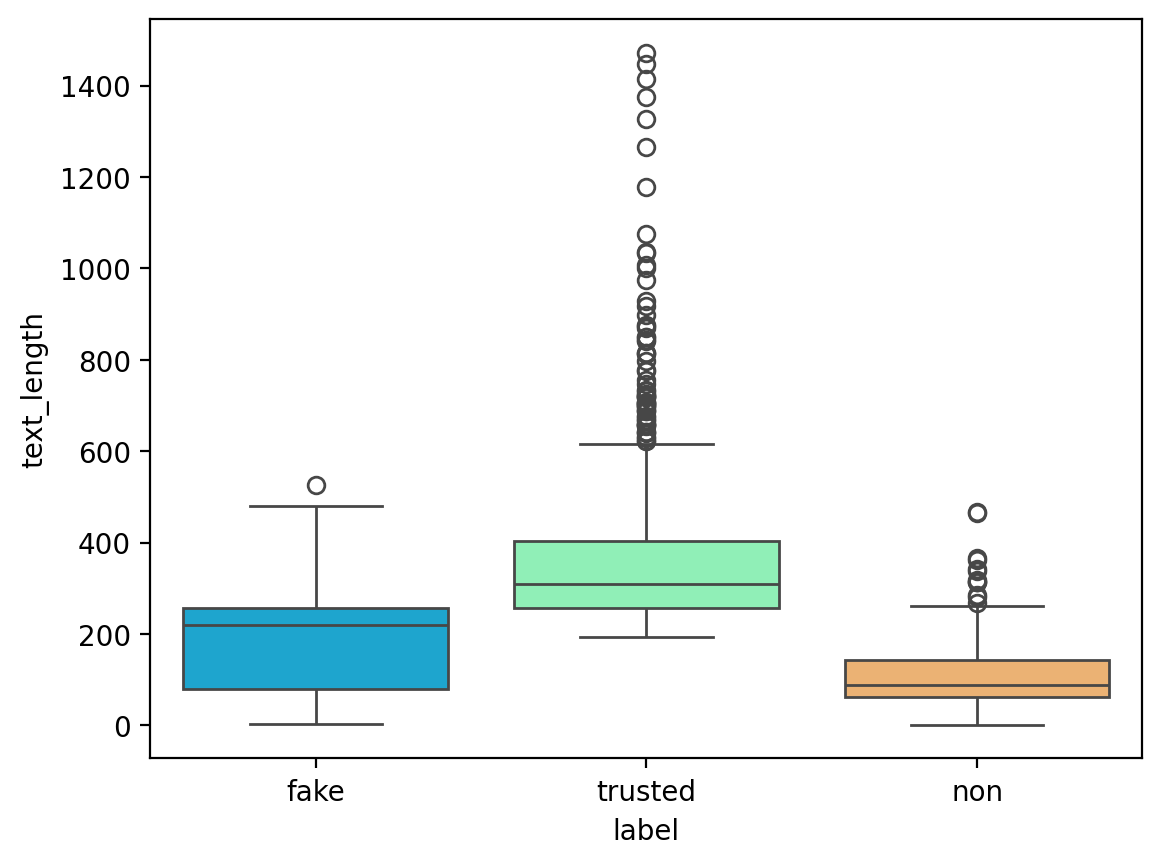

In [13]:
sns.boxplot(x='label',y='text_length',data=df,palette='rainbow')

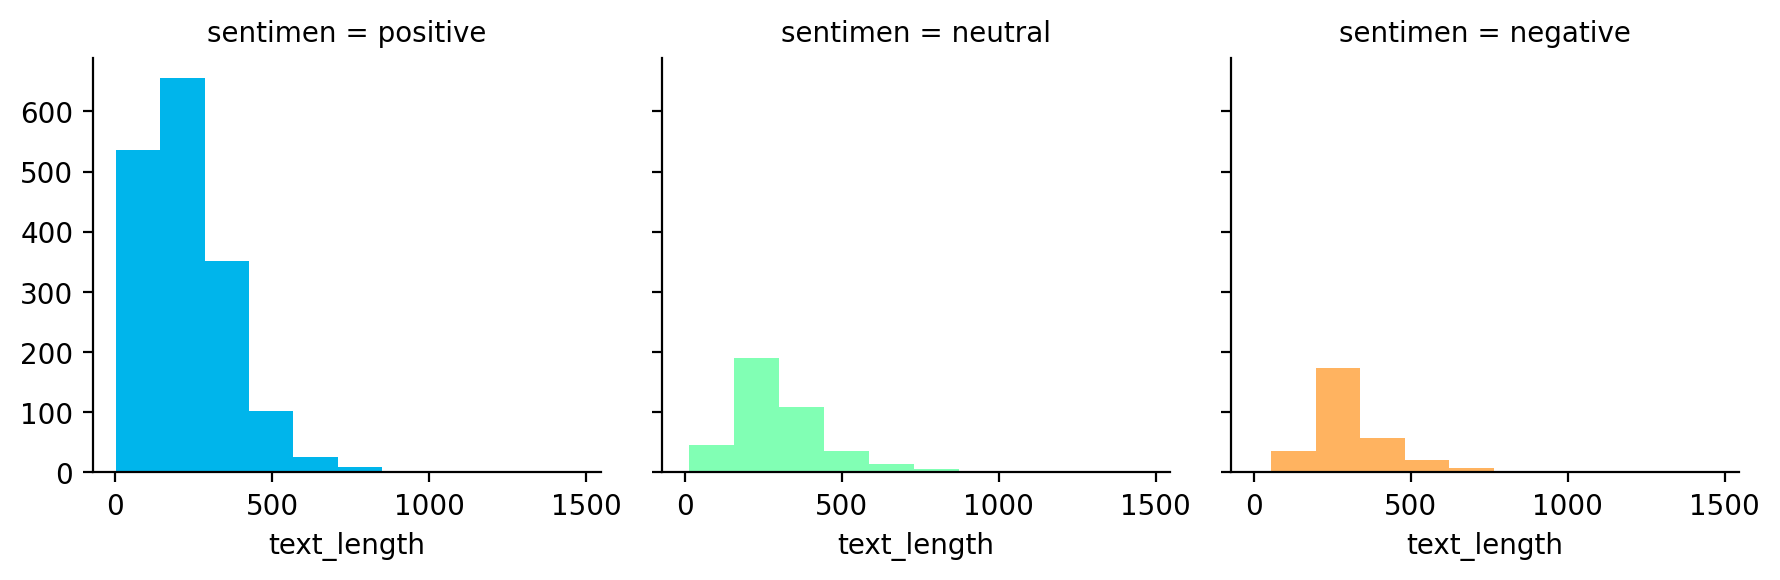

In [14]:
g = sns.FacetGrid(df, col='sentimen', hue='sentimen', palette='rainbow')
g.map(plt.hist, 'text_length')

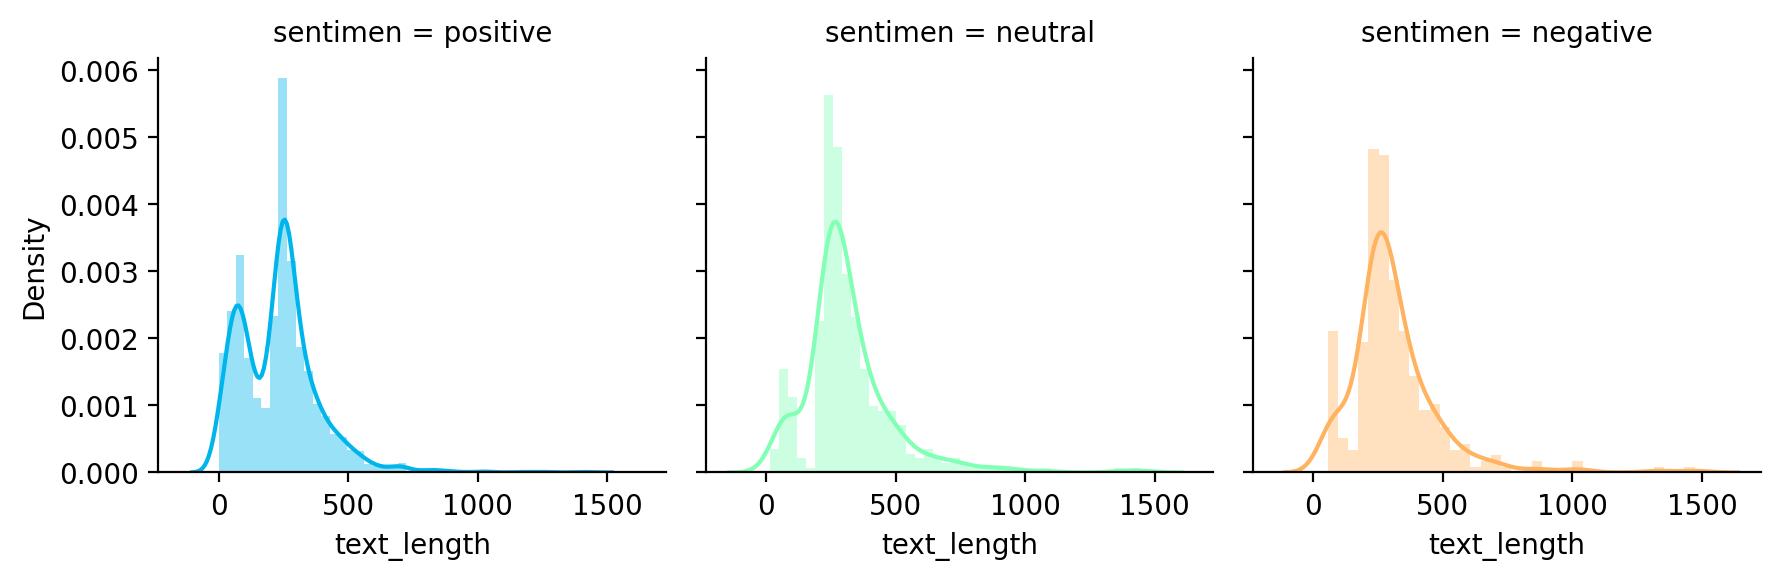

In [15]:
g = sns.FacetGrid(df, col='sentimen', hue='sentimen', palette='rainbow')
g.map(sns.distplot, 'text_length')

<Axes: xlabel='sentimen', ylabel='text_length'>

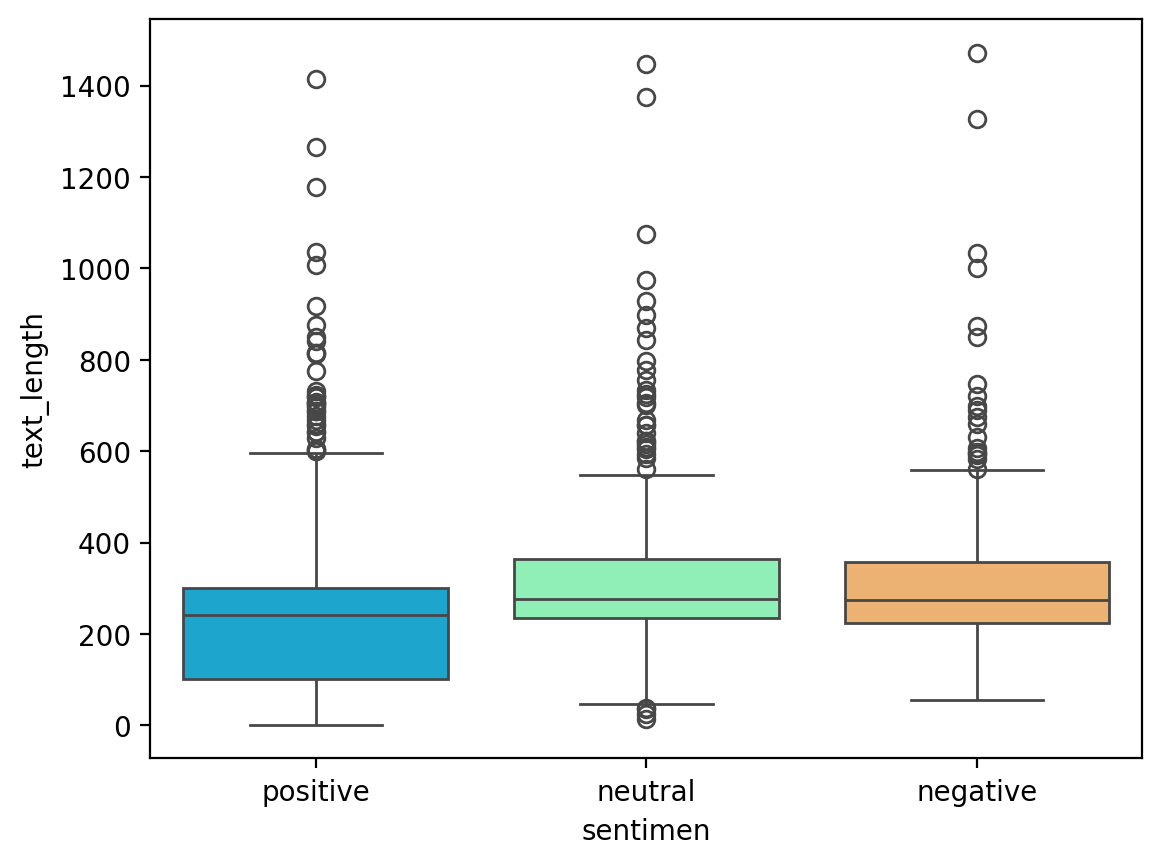

In [16]:
sns.boxplot(x='sentimen',y='text_length',data=df,palette='rainbow')

In [17]:
df['label'].value_counts()

label
trusted    1217
fake        738
non         439
Name: count, dtype: int64

## Missing Value & Duplicate handling

In [18]:
df.dropna(subset = ["label"], axis=0, inplace=True)

In [19]:
df = df.drop_duplicates()

In [20]:
df['label'].value_counts()

label
trusted    1217
fake        738
non         439
Name: count, dtype: int64

## Outliers Handling



In [21]:
df['text_length'] = df['reviews'].apply(len)

In [22]:
# #IQR
# Q1 = df['text_length'].quantile(0.25)
# Q3 = df['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

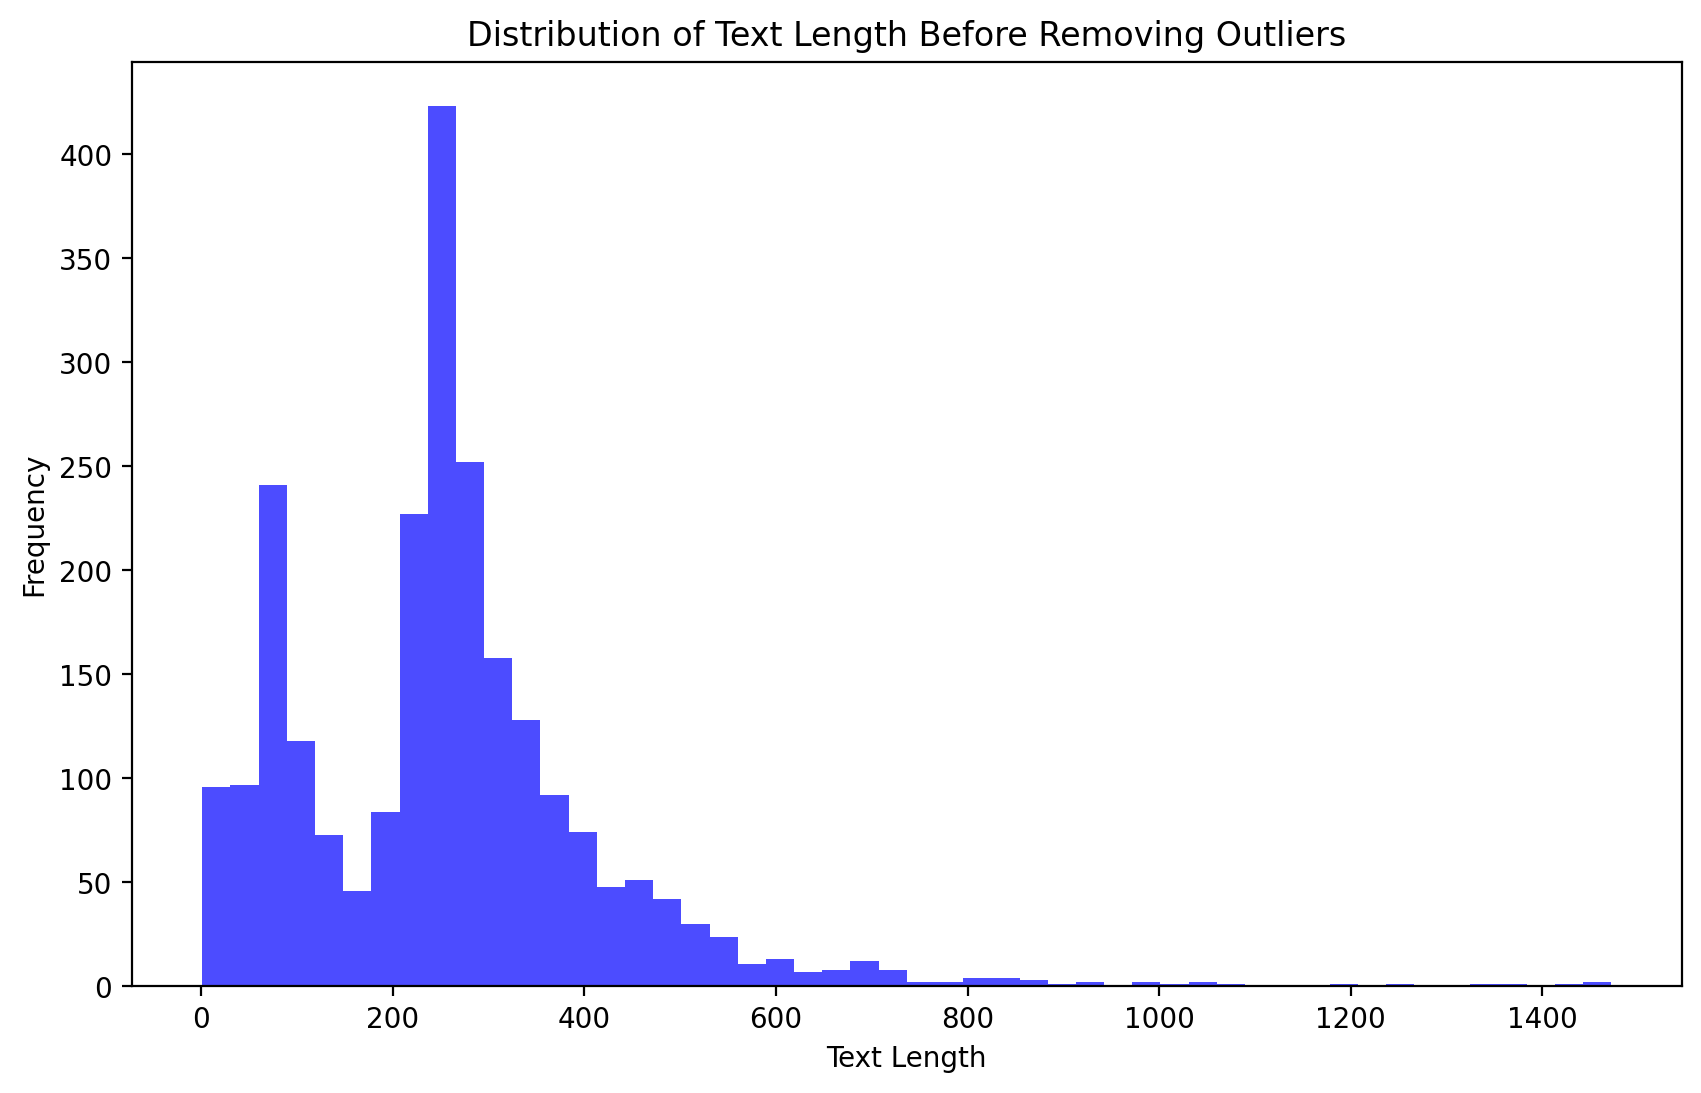

In [23]:
# Plot sebelum menghapus outlier
plt.figure(figsize=(10, 6))
df['text_length'].plot(kind='hist', bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Text Length Before Removing Outliers')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [24]:
#Isolation Forest

from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
df['anomaly_score'] = iso_forest.fit_predict(df[['text_length']])
df = df[df['anomaly_score'] == 1]



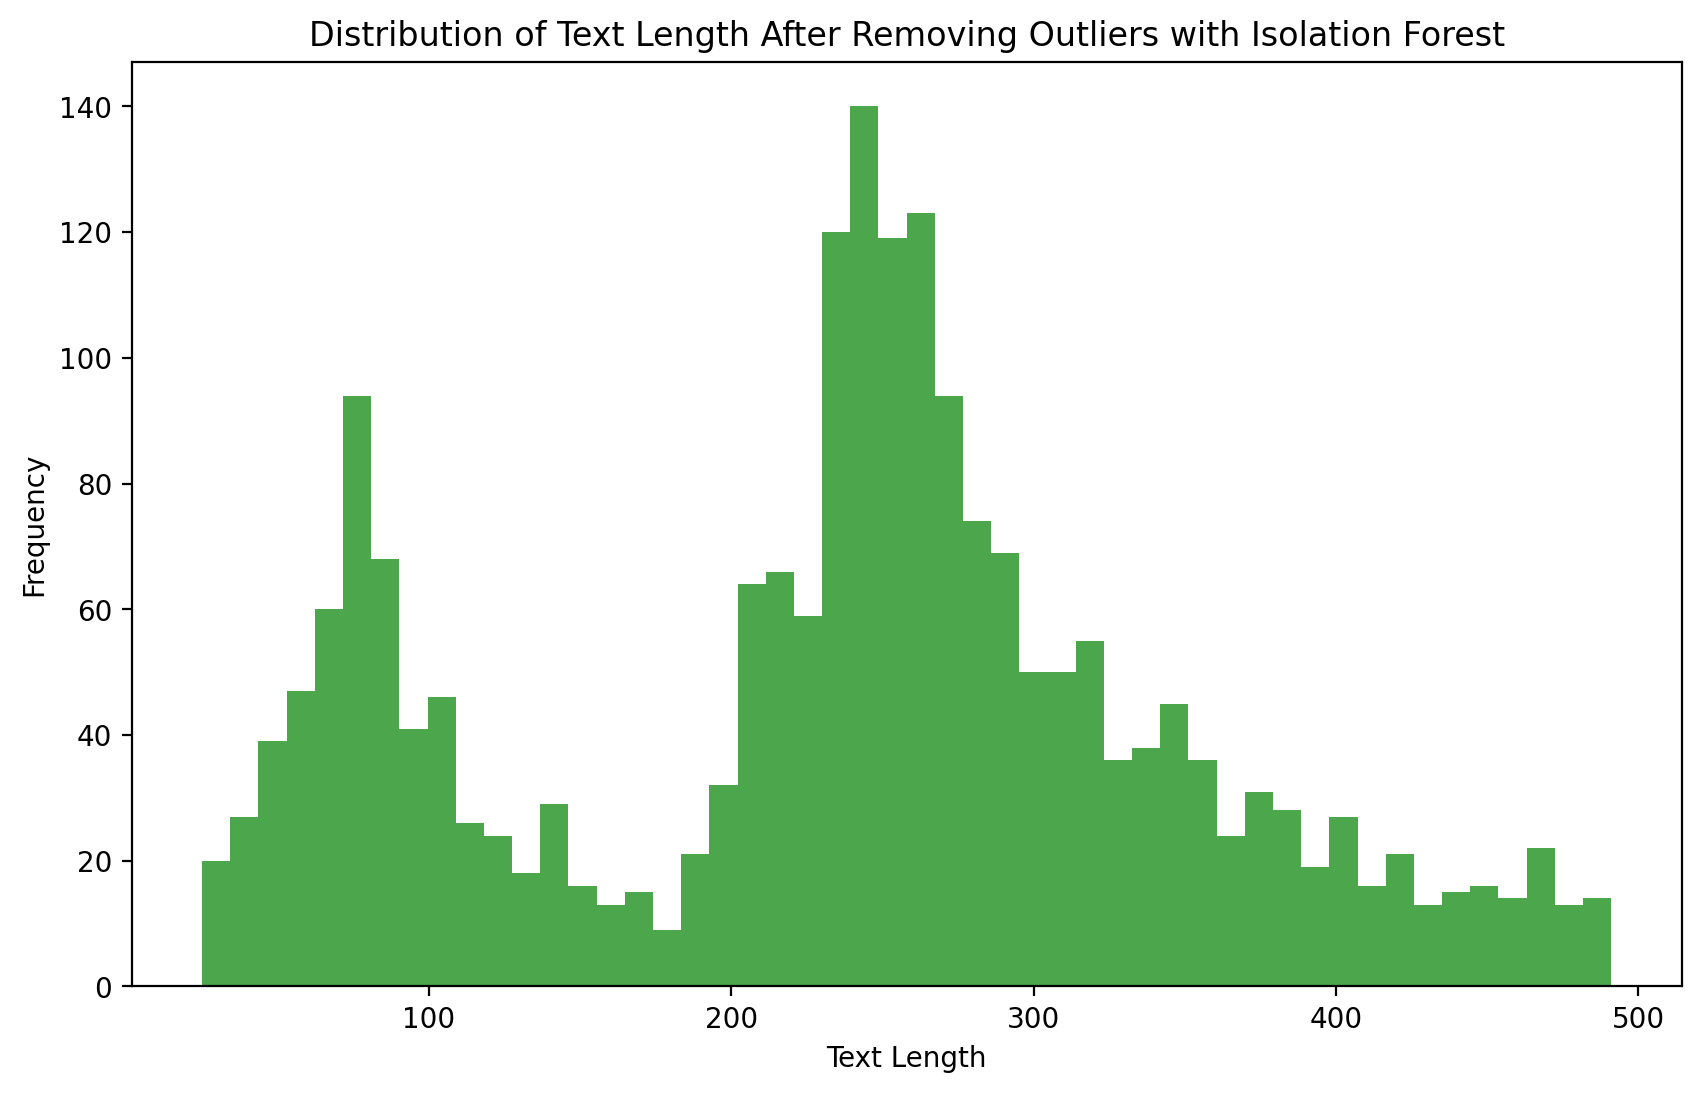

In [25]:
plt.figure(figsize=(10, 6))
df['text_length'].plot(kind='hist', bins=50, color='green', alpha=0.7)
plt.title('Distribution of Text Length After Removing Outliers with Isolation Forest')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [26]:
df.label.value_counts()

label
trusted    1064
fake        685
non         407
Name: count, dtype: int64

In [27]:
df.sentimen.value_counts()

sentimen
positive    1523
neutral      362
negative     271
Name: count, dtype: int64

### Review

<Axes: xlabel='label', ylabel='text_length'>

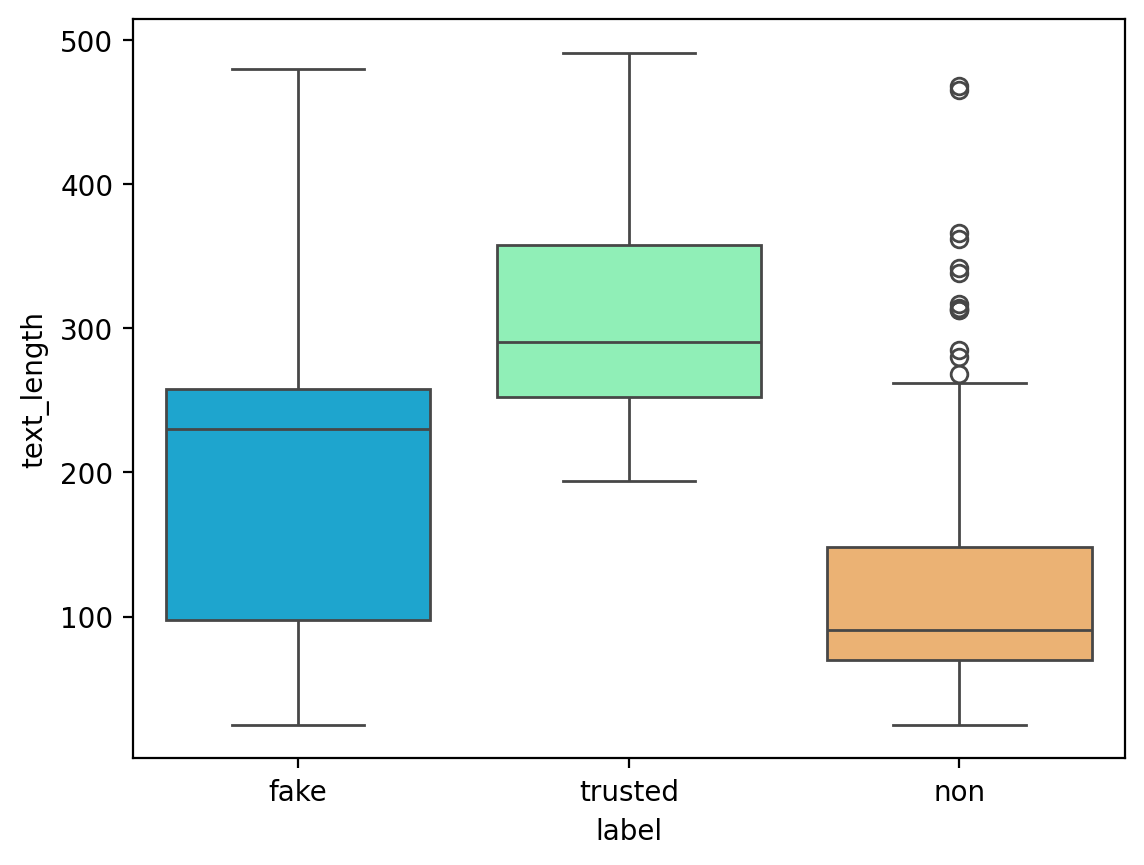

In [28]:
sns.boxplot(x='label',y='text_length',data=df,palette='rainbow')

In [29]:
# Q1 = df[df['label'] == 'fake']['text_length'].quantile(0.25)
# Q3 = df[df['label'] == 'fake']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

In [30]:
# Q1 = df[df['label'] == 'trusted']['text_length'].quantile(0.25)
# Q3 = df[df['label'] == 'trusted']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

In [31]:
# Q1 = df[df['label'] == 'non']['text_length'].quantile(0.25)
# Q3 = df[df['label'] == 'non']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

### Sentimen

<Axes: xlabel='sentimen', ylabel='text_length'>

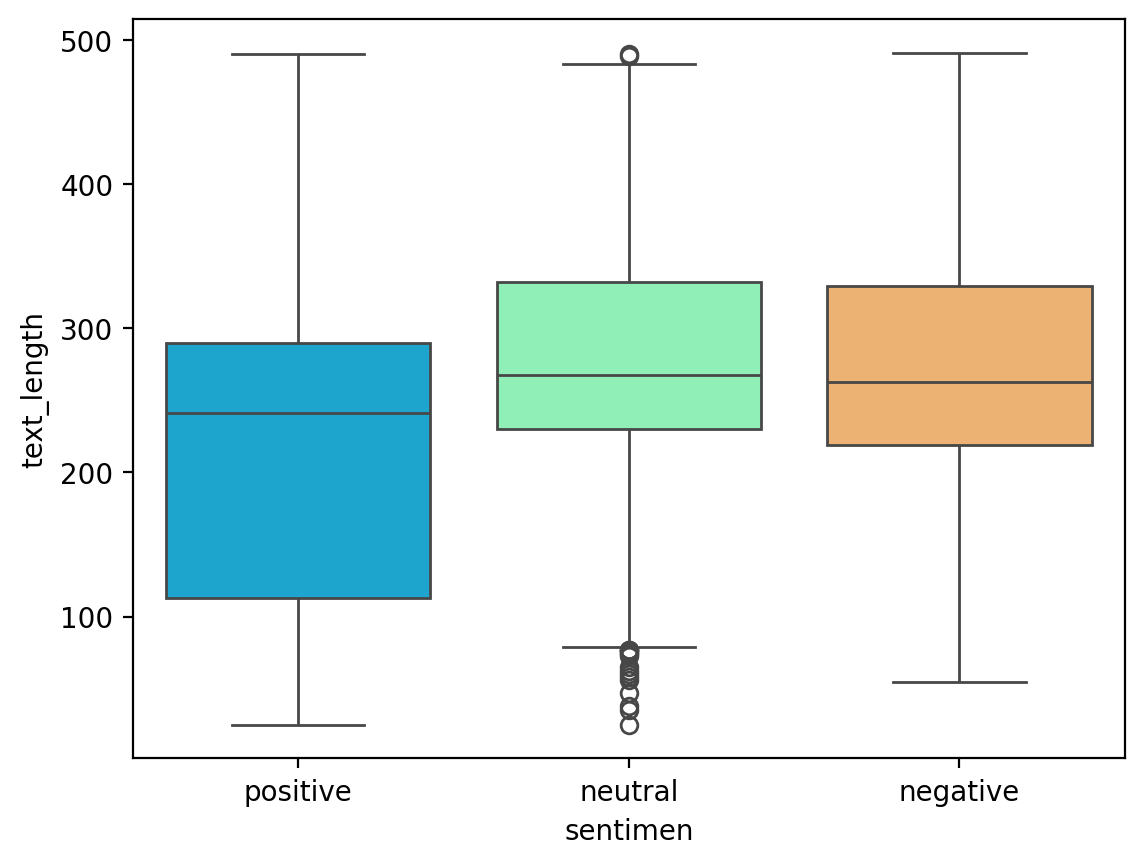

In [32]:
sns.boxplot(x='sentimen',y='text_length',data=df,palette='rainbow')

In [33]:
# Q1 = df[df['sentimen'] == 'positive']['text_length'].quantile(0.25)
# Q3 = df[df['sentimen'] == 'positive']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

In [34]:
# Q1 = df[df['sentimen'] == 'negative']['text_length'].quantile(0.25)
# Q3 = df[df['sentimen'] == 'negative']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

In [35]:
# Q1 = df[df['sentimen'] == 'neutral']['text_length'].quantile(0.25)
# Q3 = df[df['sentimen'] == 'neutral']['text_length'].quantile(0.75)
# IQR = Q3 - Q1

# df = df[~((df['text_length'] < (Q1-1.5*IQR)) | (df['text_length'] > (Q3+1.5*IQR)))]

## Show Final Distrubution & Outlier

### Review

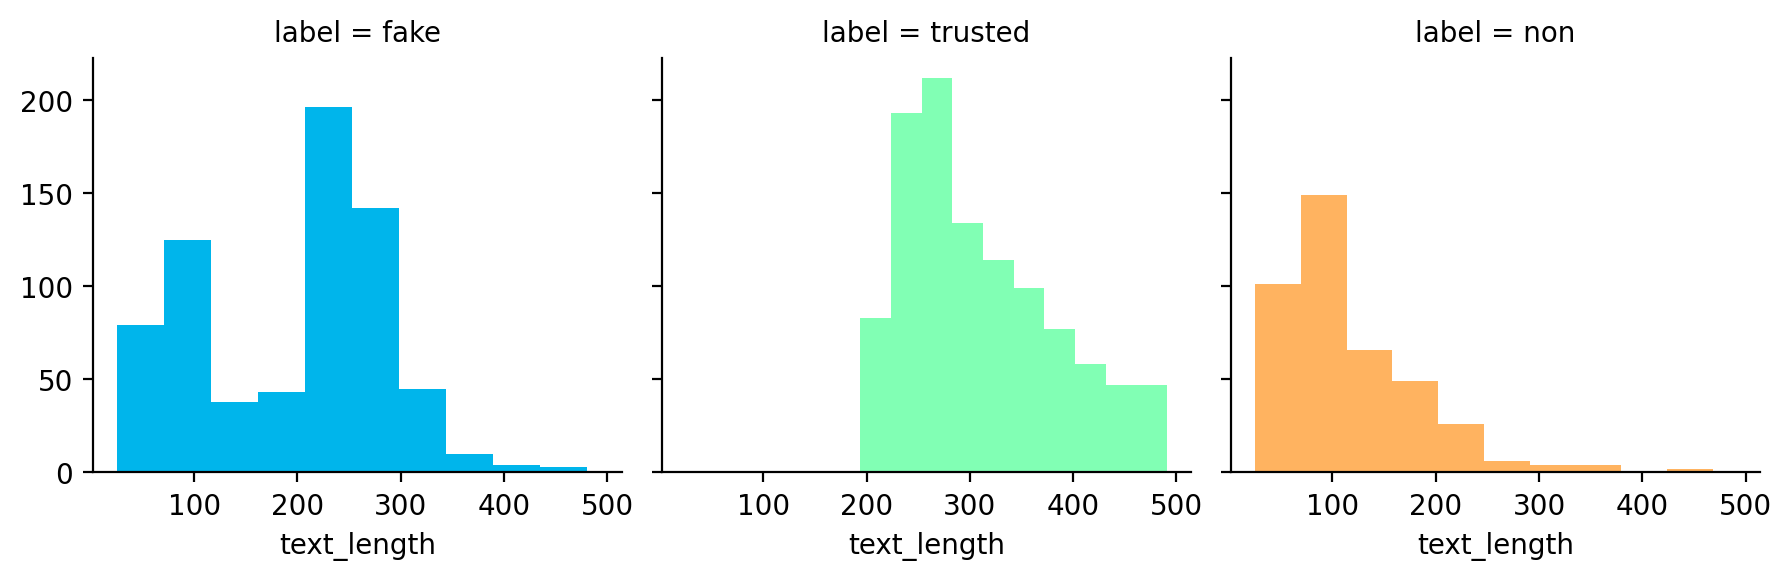

In [36]:
g = sns.FacetGrid(df, col='label', hue='label', palette='rainbow')
g.map(plt.hist, 'text_length')

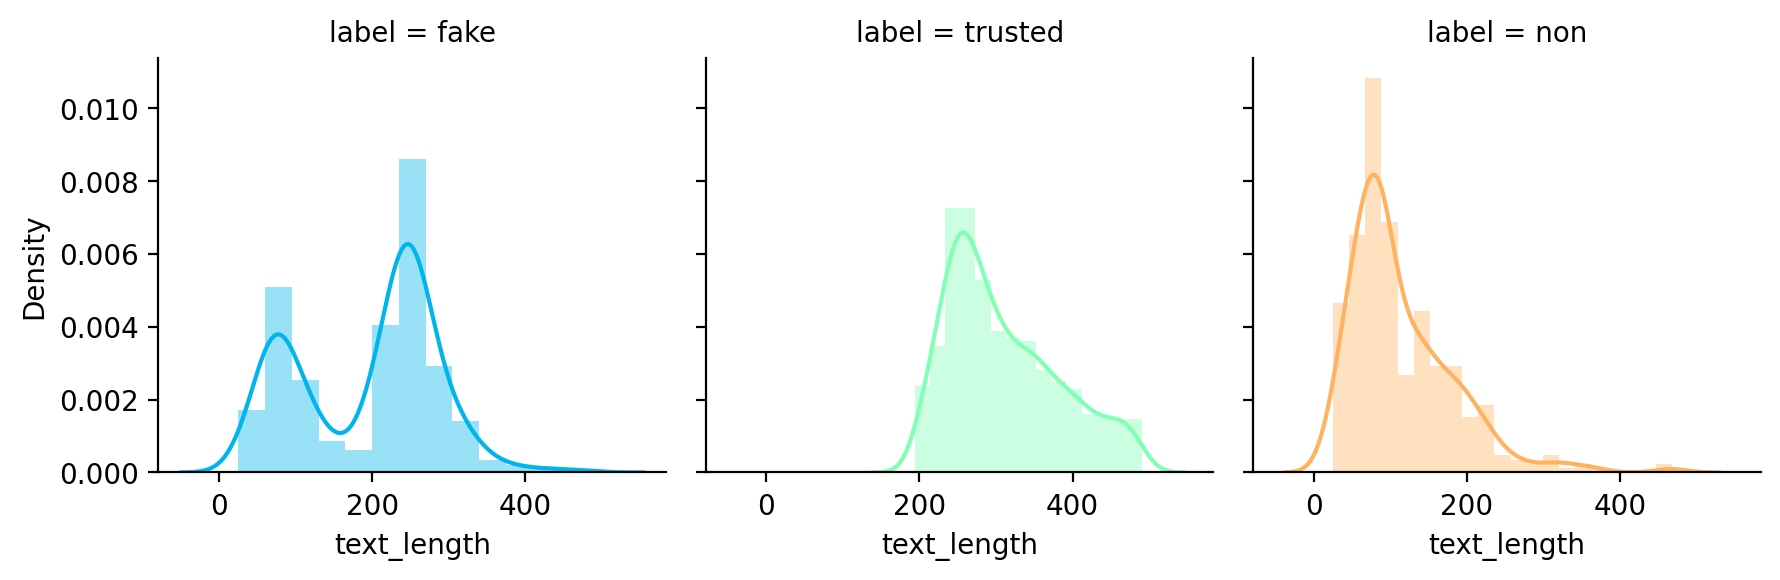

In [37]:
g = sns.FacetGrid(df, col='label', hue='label', palette='rainbow')
g.map(sns.distplot, 'text_length')

<Axes: xlabel='label', ylabel='text_length'>

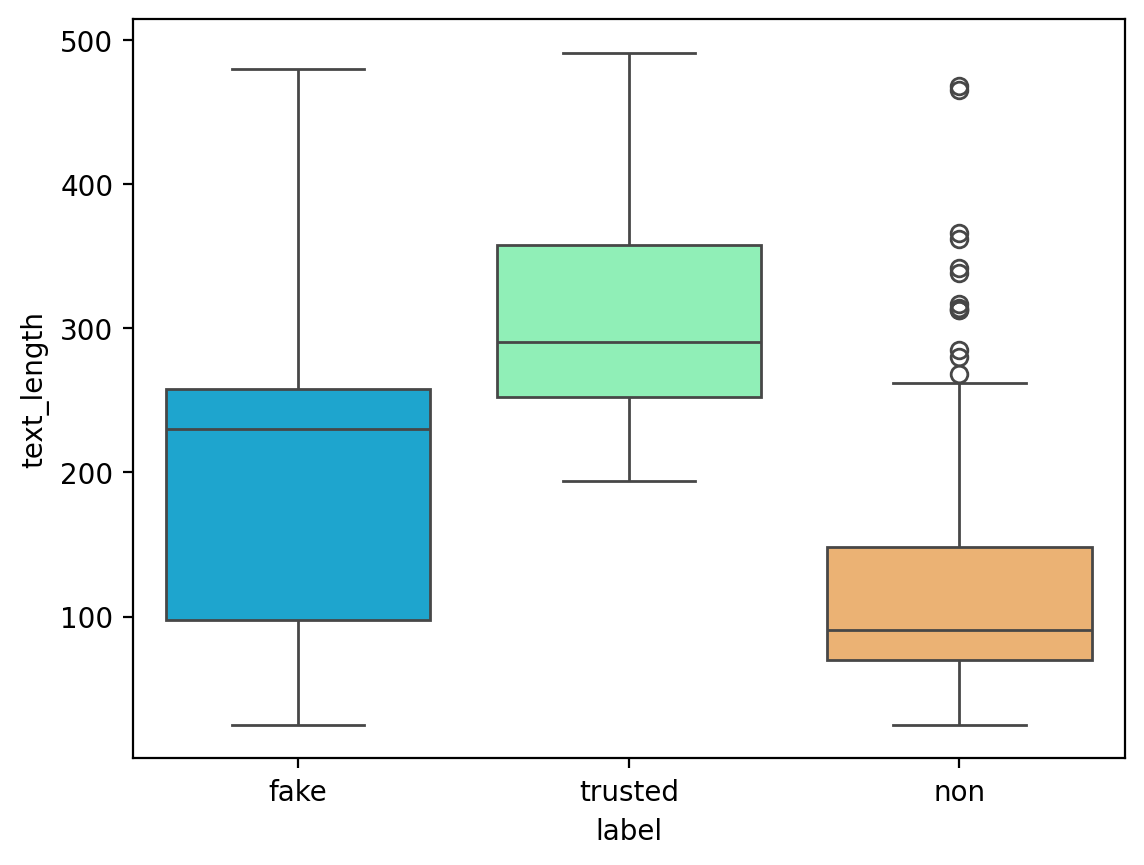

In [38]:
sns.boxplot(x='label',y='text_length',data=df,palette='rainbow')

### Sentimen

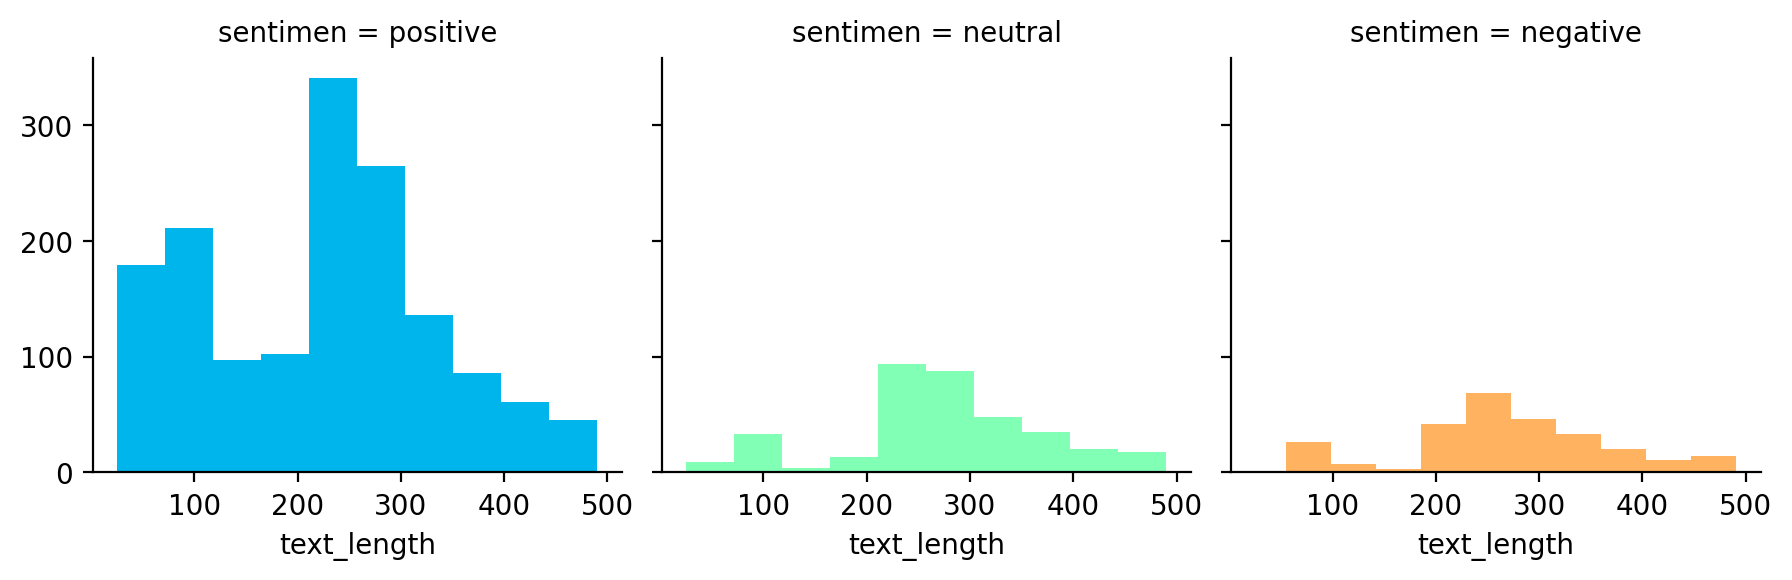

In [39]:
g = sns.FacetGrid(df, col='sentimen', hue='sentimen', palette='rainbow')
g.map(plt.hist, 'text_length')

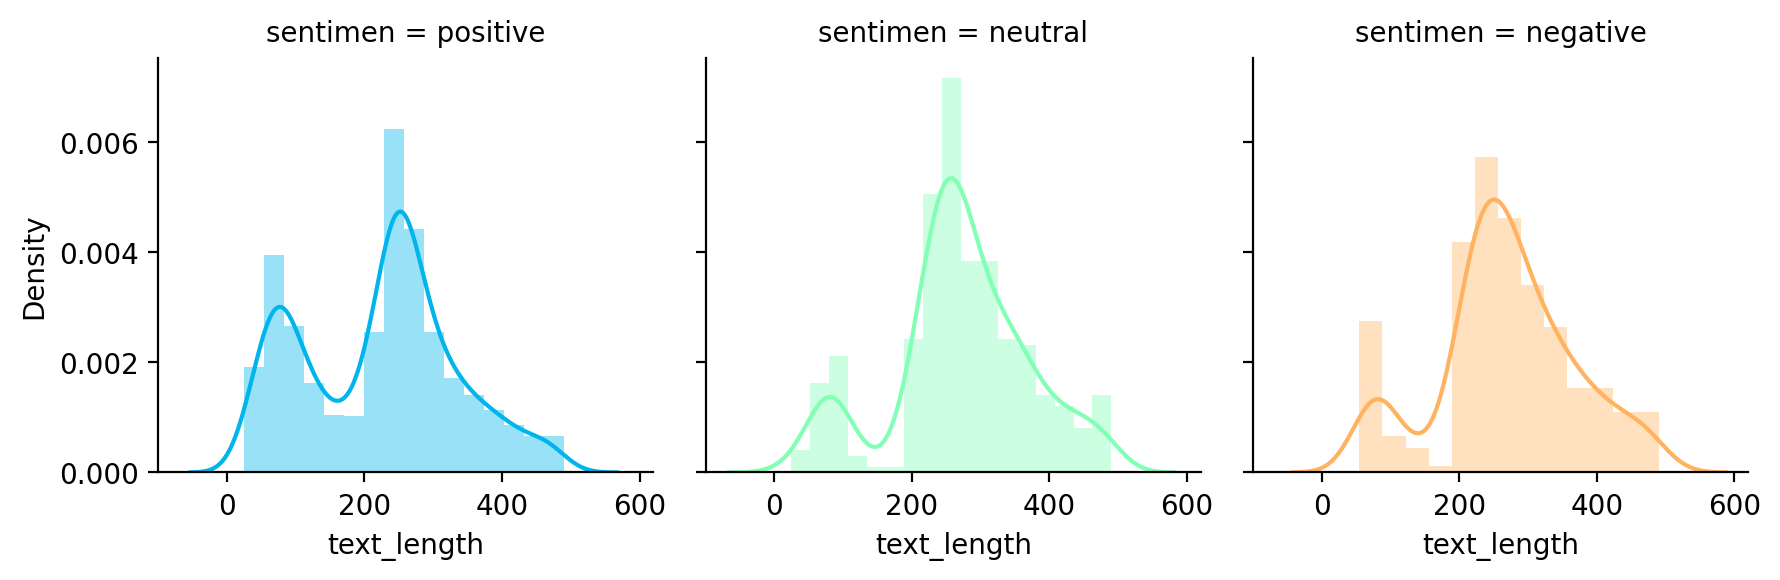

In [40]:
g = sns.FacetGrid(df, col='sentimen', hue='sentimen', palette='rainbow')
g.map(sns.distplot, 'text_length')

<Axes: xlabel='sentimen', ylabel='text_length'>

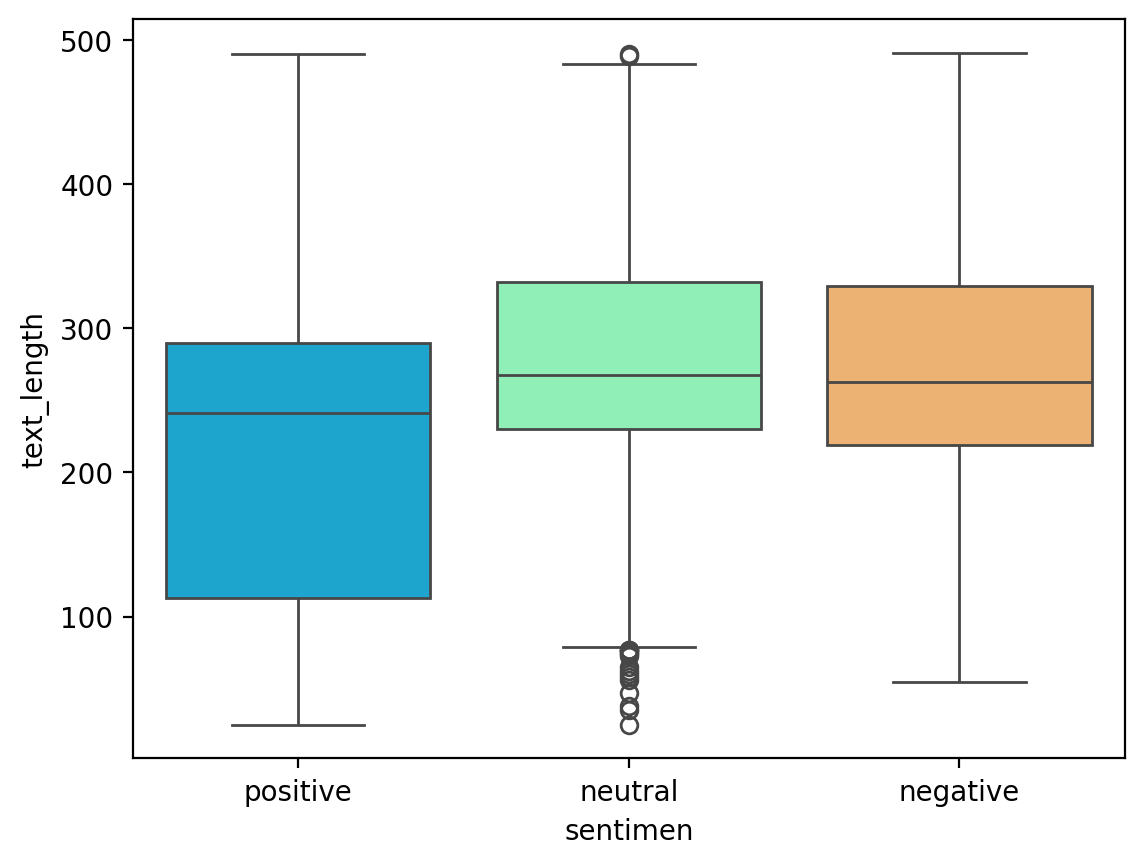

In [41]:
sns.boxplot(x='sentimen',y='text_length',data=df,palette='rainbow')

## Imbalance Class Handling

In [42]:
df.label.value_counts()

label
trusted    1064
fake        685
non         407
Name: count, dtype: int64

In [43]:
# Resample data
label_trusted = resample(df[df['label'] == 'trusted'],
                                 replace=True,
                                 n_samples=700,
                                 random_state=123)

label_fake = resample(df[df['label'] == 'fake'],
                                 replace=True,
                                 n_samples=700,
                                 random_state=123)

label_non = resample(df[df['label'] == 'non'],
                                 replace=True,
                                 n_samples=700,
                                 random_state=123)

# Gabung ulang
df = pd.concat([label_trusted, label_fake, label_non])

df.label.value_counts()

label
trusted    700
fake       700
non        700
Name: count, dtype: int64

In [44]:
df.sentimen.value_counts()

sentimen
positive    1579
neutral      299
negative     222
Name: count, dtype: int64

In [45]:
# Resample data
sentimen_neutral = resample(df[df['sentimen'] == 'neutral'],
                                 replace=True,
                                 n_samples=700,
                                 random_state=123)

sentimen_positive = resample(df[df['sentimen'] == 'positive'],
                                 replace=True,
                                 n_samples=700,
                                 random_state=123)

sentimen_negative = resample(df[df['sentimen'] == 'negative'],
                                 replace=True,
                                 n_samples=700,
                                 random_state=123)

# Gabung ulang
df = pd.concat([sentimen_neutral, sentimen_positive, sentimen_negative])

df.sentimen.value_counts()

sentimen
neutral     700
positive    700
negative    700
Name: count, dtype: int64

# Features Engeneering


## Remove Link, Hastag, Mention, Emoji

In [46]:
def cleanUpTweet(txt):
    txt = re.sub(r'@[A-Za-z0-9_]+', '', txt) #Remove mentions
    txt = re.sub(r'#[A-Za-z0-9_]+', '', txt) #Remove hashtags
    txt = re.sub(r'RT ', '', txt) #Remove retweets
    txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', txt) #Remove urls
    return txt

In [47]:
def stripEmoji(txt):
  txt = re.sub(emoji.get_emoji_regexp(), r'', txt)
  return txt

## Remove HTML Char


In [48]:
def removeHTMLChar(text):
    text = ' '.join(re.sub("([&][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    return text

## Remove Punctuation

In [49]:
def remove_punctuation(txt):
  txt = re.sub(r'[^\w\s]', ' ', txt)
  return txt

In [50]:
df['reviews'] = df['reviews'].apply(remove_punctuation)

In [51]:
df['reviews'].iloc[99]

'Dulu banget pas smp cocok sama produk ini sekarang pas coba lagi jadinya terlalu kering diwajahku  apakah ini yg dinamakan semakin tua semakin berkurang ya minyak alami di kulit   setelah cuci muka jadi terlalu kering'

In [52]:
df.head()

,username,rate,date,label,sentimen,reviews,produk,text_length,anomaly_score
843,ADLusari,3,30-08-2023 2:18,trusted,neutral,So so lah ya untuk facewash harga segini bagu...,Acnes Creamy Wash,300,1
1378,MuthiaBilqis,3,17-04-2021 20:48,fake,neutral,dulu pas masih waktu SMA sempet pake ini awal...,Acnes Creamy Wash,301,1
626,dunianyabunga,3,26-11-2015 4:08,trusted,neutral,dari semua shade la girl ini paling favorit da...,Lip Cream LA Girl,272,1
1026,cacaca3004,3,17-02-2022 12:06,trusted,neutral,saat pakai produk ini dan bilas face wash ini...,Acnes Creamy Wash,425,1
1363,Malafbrns,3,28-04-2021 1:37,trusted,neutral,Nyobain produk ini karena cleanser yang biasa ...,Acnes Creamy Wash,437,1


## Remove Whitespace

In [53]:
def remove_whitespace_LT(text):
    return text.strip()

In [54]:
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

In [55]:
def spell(word):
    if re.search(r'([a-zA-Z])\1{2,}', word):
        rword = re.sub(r'([a-zA-Z])\1{2,}','\\1', word)
        return rword
    else:
        return word

In [56]:
df['reviews'] = df['reviews'].apply(remove_whitespace_LT)
df['reviews'] = df['reviews'].apply(remove_whitespace_multiple)
df['reviews'] = df['reviews'].apply(spell)

## To Lowercase

In [57]:
df["reviews"] = df["reviews"].apply(lambda item: str(item).lower())

## Remove Special Character

In [58]:
def remove_text_special(text):
    # hapus tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # hapus non ASCII (emot, bahasa china dll)
    text = text.encode('ascii', 'replace').decode('ascii')
    # hapus mention, link, hashtag
    # text = text.replace("rt", "") # revisi
    text = ' '.join(re.sub("([@#&][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove URL
    return text.replace("http://", " ").replace("https://", " ")

In [59]:
df['reviews'] = df.reviews.astype('str')
df['reviews'] = df['reviews'].apply(remove_text_special)

In [60]:
df['reviews'].iloc[88]

'gagal dipake di bibir gw lengket n ngletek gitu dipake padahal udah gw mangap2in bibir biar kering sempurna tp tetep aja g bagus hasilnya kecewa banget karena gw suka warnanya hikss akhirnya gw preloved biar dapet majikan baru syg bgt deh'

# Tokenize

In [61]:
from nltk.tokenize import word_tokenize
def word_tokenize_wrapper(text):
    return word_tokenize(text)

def tokenize(word):
  word = word.split(" ")
  return word

In [62]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [63]:
df['reviews_tokens'] = df['reviews'].apply(word_tokenize_wrapper)

# Count Word

In [64]:
from collections import defaultdict
word_count = defaultdict(int)
for tokens in df["reviews_tokens"]:
    for token in tokens:
       word_count[token] += 1

In [65]:
word_count_df = pd.DataFrame({"key": word_count.keys(), "count": word_count.values()})
word_count_df_sort = word_count_df.sort_values('count', axis=0, ascending=False, inplace=False)
word_count_df_sort.head(10)

,key,count
51,ini,1875
58,dan,1807
23,aku,1735
248,di,1304
89,banget,1147
118,yang,958
67,cocok,857
54,ga,850
11,tapi,832
50,pake,790


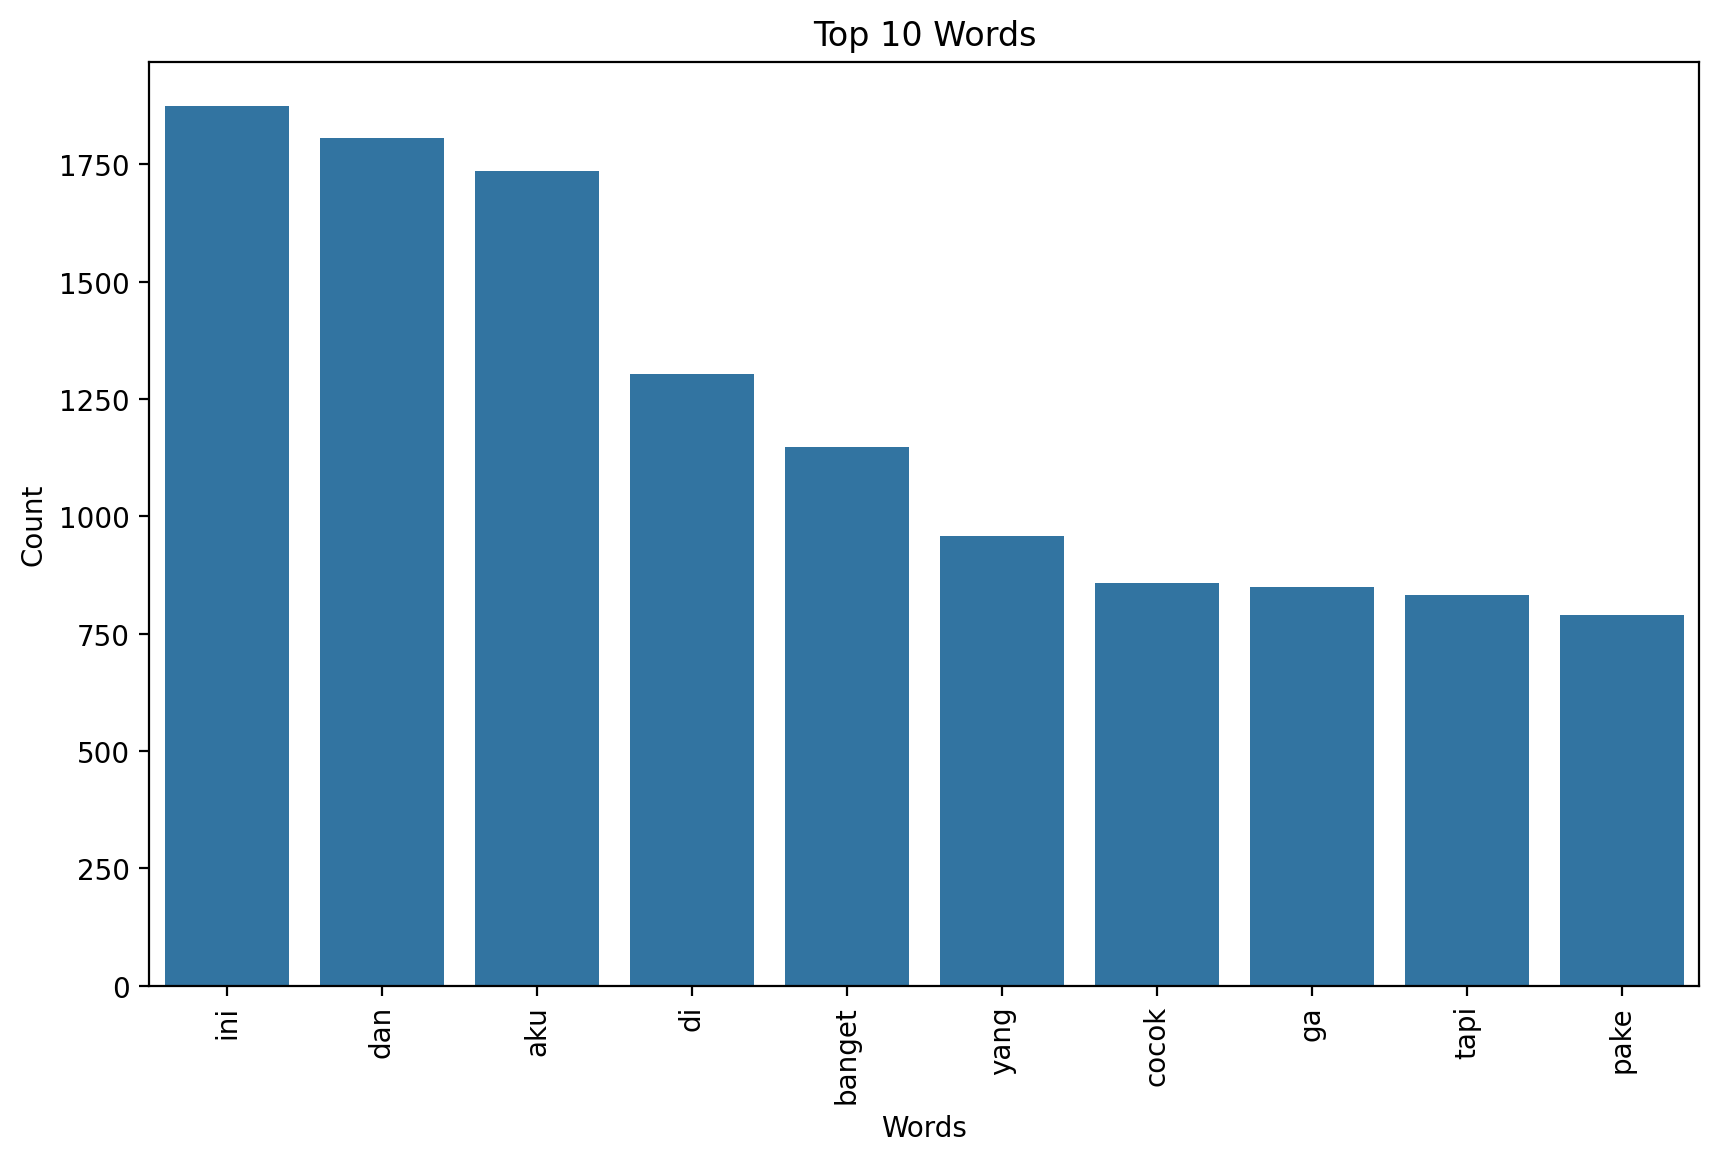

In [66]:
top_10_words = word_count_df_sort.head(10)
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='key', y='count', data=top_10_words, ax=ax)
plt.title("Top 10 Words")
plt.xlabel("Words")
plt.ylabel("Count")
plt.xticks(rotation='vertical')
plt.show()

# Stopword Removal

In [67]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [68]:
from nltk.corpus import stopwords

In [69]:
list_stopwords = stopwords.words('indonesian')
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo',
                       'kalo', 'amp', 'biar', 'bikin', 'bilang',
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya',
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't',
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       'yah'])

txt_stopword = pd.read_csv("https://raw.githubusercontent.com/Fake-Review-Detection-Spiill-AI/screnario-2---multi-task/82c73387636132ec7faa30c99ef5e788b3bf62bd/stopwords.txt", names= ["stopwords"], header = None)
list_stopwords.extend(txt_stopword["stopwords"][0].split(' '))
list_stopwords = set(list_stopwords)
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]
df['reviews_tokens_WSW'] = df['reviews_tokens'].apply(stopwords_removal)

# Stemming

In [70]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter

In [71]:
df_normalized = pd.DataFrame(df['label'])
df_normalized['reviews'] = df['reviews']

In [72]:
normalizad_word = df_normalized

normalizad_word_dict = {}

for index, row in normalizad_word.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1]

def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

df['reviews_normalized'] = df['reviews_tokens_WSW'].apply(normalized_term)


# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in df['reviews_normalized']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '

print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])

print(term_dict)
print("------------------------")


# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

df['reviews_tokens_stemmed'] = df['reviews_normalized'].swifter.apply(get_stemmed_term)

2900
------------------------
facewash : facewash
harga : harga
segini : gin
bagus : bagus
engga : engga
jelek : jelek
emang : emang
ketatik : ketatik
kulitku : kulit
separah : parah
coba : coba
jerawatan : jerawat
ngestrip : ngestrip
kulit : kulit
huhu : huhu
beli : beli
tube : tube
sanggup : sanggup
habiskan : habis
pas : pas
sma : sma
sempet : sempet
pake : pake
pemakaian : pakai
muncul : muncul
apapun : apa
jerawat : jerawat
mereda : reda
cocok : cocok
bruntusan : bruntusan
yaudah : yaudah
ganti : ganti
face : face
wash : wash
remaja : remaja
wajib : wajib
xixi : xixi
shade : shade
girl : girl
favorit : favorit
keliatan : liat
natural : natural
banget : banget
dipake : dipake
sehari : hari
packagingnya : packagingnya
standar : standar
isinya : isi
lumayan : lumayan
suka : suka
berasa : asa
kaya : kaya
lilin : lilin
hasilnya : hasil
matte : matte
cepet : cepet
kering : kering
pakai : pakai
produk : produk
bilas : bilas
kasih : kasih
efek : efek
keseet : keseet
mukaku : muka
berminya

Pandas Apply:   0%|          | 0/2100 [00:00<?, ?it/s]

# Merge

In [73]:
def merge_again(text):
    return ' '.join(text)

In [74]:
df['done_reviews'] = df['reviews_tokens_stemmed'].apply(merge_again)

In [75]:
for i in range(51):
  print(df['done_reviews'].iloc[i])

facewash harga gin bagus engga jelek engga emang ketatik kulit parah coba jerawat ngestrip kulit huhu beli engga engga tube sanggup habis
pas sma sempet pake pakai bagus muncul apa jerawat reda engga cocok muncul bruntusan yaudah ganti face wash remaja wajib coba xixi
shade girl favorit liat natural cocok banget dipake hari packagingnya standar isi lumayan suka pake asa kaya pake lilin hasil matte cepet kering
pakai produk bilas face wash kasih efek keseet banget kering muka minyak suka wangi produk pakai face wash munculin reaksi negatif suka after feelnya kulit keset abiez lebih harga murah gampang cari mana repurchase duluu
nyobain produk cleanser pakai stok kosong dibeliin tekstur cream busa ngga pikir cocok sma produk hasil bilas wajah keset kering pakai 2 minggu hasil ngga ngefek apa2 breakout numbuhin jerawat gede jarang banget jerawat gede
suka banget warna pake kuat ngabisin 1 botol karna suka warna sampe nemu persis kaya warna fleur lengket banget habis makan touch up bagus h

# Modeling

In [76]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, concatenate, Dropout, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.regularizers import l1, l2
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from keras.optimizers import Adam


In [77]:
# Encode labels
label_encoder_review = LabelEncoder()
label_encoder_sentiment = LabelEncoder()
df['label_encoded'] = label_encoder_review.fit_transform(df['label'])
df['sentiment_encoded'] = label_encoder_sentiment.fit_transform(df['sentimen'])

In [78]:
# Tokenization and Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['done_reviews'])
sequences = tokenizer.texts_to_sequences(df['done_reviews'])
word_index = tokenizer.word_index

In [79]:
# Padding sequences
max_sequence_length = 100  # Adjust as needed
data = pad_sequences(sequences, maxlen=max_sequence_length)

In [80]:
# Prepare embedding matrix with Word2Vec
w2v_model = Word2Vec(sentences=[text.split() for text in df['done_reviews']], vector_size=100, window=5, min_count=1, workers=4)
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [81]:
# Split the data
X_train, X_test, y_train_label, y_test_label, y_train_sentiment, y_test_sentiment = train_test_split(
    data, df['label_encoded'], df['sentiment_encoded'], test_size=0.2, random_state=42
)

In [82]:
# Define the model
input_ = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=max_sequence_length, trainable=False)
embedding_layer.build((None,))  # Build the embedding layer
embedding_layer.set_weights([embedding_matrix])  # Set the weights of the embedding layer

embedding = embedding_layer(input_)
embedding = Dropout(0.5)(embedding)

In [83]:
# Convolutional layer
conv = Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01))(embedding)
conv = MaxPooling1D(pool_size=2)(conv)
conv = Dropout(0.5)(conv)


In [84]:
# # LSTM layer
# lstm_out = LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))(embedding)
# lstm_out = Dropout(0.5)(lstm_out)  # Add dropout after first LSTM
# lstm_out = LSTM(64, kernel_regularizer=l2(0.01))(lstm_out)
# lstm_out = Dropout(0.5)(lstm_out)  # Add dropout after second LSTM

In [85]:
# Bidirectional LSTM layers
lstm_out = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)))(conv)
lstm_out = Dropout(0.5)(lstm_out)  # Add dropout after first Bidirectional LSTM
lstm_out = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01)))(lstm_out)
lstm_out = Dropout(0.5)(lstm_out)  # Add dropout after second Bidirectional LSTM
lstm_out = LSTM(32, kernel_regularizer=l2(0.01))(lstm_out)
lstm_out = Dropout(0.5)(lstm_out)  # Add dropout after third LSTM

In [86]:
# Additional Dense and Dropout layers
dense_out = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(lstm_out)
dense_out = Dropout(0.5)(dense_out)
dense_out = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dense_out)
dense_out = Dropout(0.5)(dense_out)
dense_out = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(dense_out)
dense_out = Dropout(0.5)(dense_out)

In [87]:
# Output layers
output_review = Dense(3, activation='softmax', name='review_output', kernel_regularizer=l2(0.01))(dense_out)
output_sentiment = Dense(3, activation='softmax', name='sentiment_output', kernel_regularizer=l2(0.01))(dense_out)


In [88]:
# Combine into a model
model = Model(inputs=input_, outputs=[output_review, output_sentiment])
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam',
#               loss={'review_output': 'sparse_categorical_crossentropy', 'sentiment_output': 'sparse_categorical_crossentropy'},
#               metrics={'review_output': 'accuracy', 'sentiment_output': 'accuracy'})


In [89]:
# Summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 100)             246700    ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 100, 100)             0         ['embedding[0][0]']           
                                                                                                  
 conv1d (Conv1D)             (None, 96, 64)               32064     ['dropout[0][0]']             
                                                                                              

In [90]:
# Compile the model with metrics for each output
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer='adam',
              loss={'review_output': 'sparse_categorical_crossentropy', 'sentiment_output': 'sparse_categorical_crossentropy'},
              metrics={'review_output': 'accuracy', 'sentiment_output': 'accuracy'})

In [91]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define Early Stopping and Model Checkpoint callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

In [92]:
# Train the model with callbacks
history = model.fit(
    X_train,
    {'review_output': y_train_label, 'sentiment_output': y_train_sentiment},
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/30
42/42 [==============================] - 28s 395ms/step - loss: 9.6898 - review_output_loss: 1.0826 - sentiment_output_loss: 1.1046 - review_output_accuracy: 0.3839 - sentiment_output_accuracy: 0.3326 - val_loss: 6.5320 - val_review_output_loss: 1.0295 - val_sentiment_output_loss: 1.1033 - val_review_output_accuracy: 0.5179 - val_sentiment_output_accuracy: 0.3185
Epoch 2/30
42/42 [==============================] - 13s 301ms/step - loss: 4.9635 - review_output_loss: 0.9725 - sentiment_output_loss: 1.1161 - review_output_accuracy: 0.4725 - sentiment_output_accuracy: 0.3125 - val_loss: 3.8241 - val_review_output_loss: 0.9629 - val_sentiment_output_loss: 1.1044 - val_review_output_accuracy: 0.5179 - val_sentiment_output_accuracy: 0.2946
Epoch 3/30
42/42 [==============================] - 13s 311ms/step - loss: 3.2776 - review_output_loss: 0.9229 - sentiment_output_loss: 1.1098 - review_output_accuracy: 0.4874 - sentiment_output_accuracy: 0.3170 - val_loss: 2.8009 - val_review_ou

In [93]:
# Evaluate the model
results = model.evaluate(X_test, {'review_output': y_test_label, 'sentiment_output': y_test_sentiment})
print(f'Test results - Loss: {results[0]} - Review Output Loss: {results[1]} - Sentiment Output Loss: {results[2]}')

14/14 [==============================] - 1s 76ms/step - loss: 1.8933 - review_output_loss: 0.7282 - sentiment_output_loss: 1.0869 - review_output_accuracy: 0.7048 - sentiment_output_accuracy: 0.3833
Test results - Loss: 1.8933093547821045 - Review Output Loss: 0.7281977534294128 - Sentiment Output Loss: 1.0868512392044067


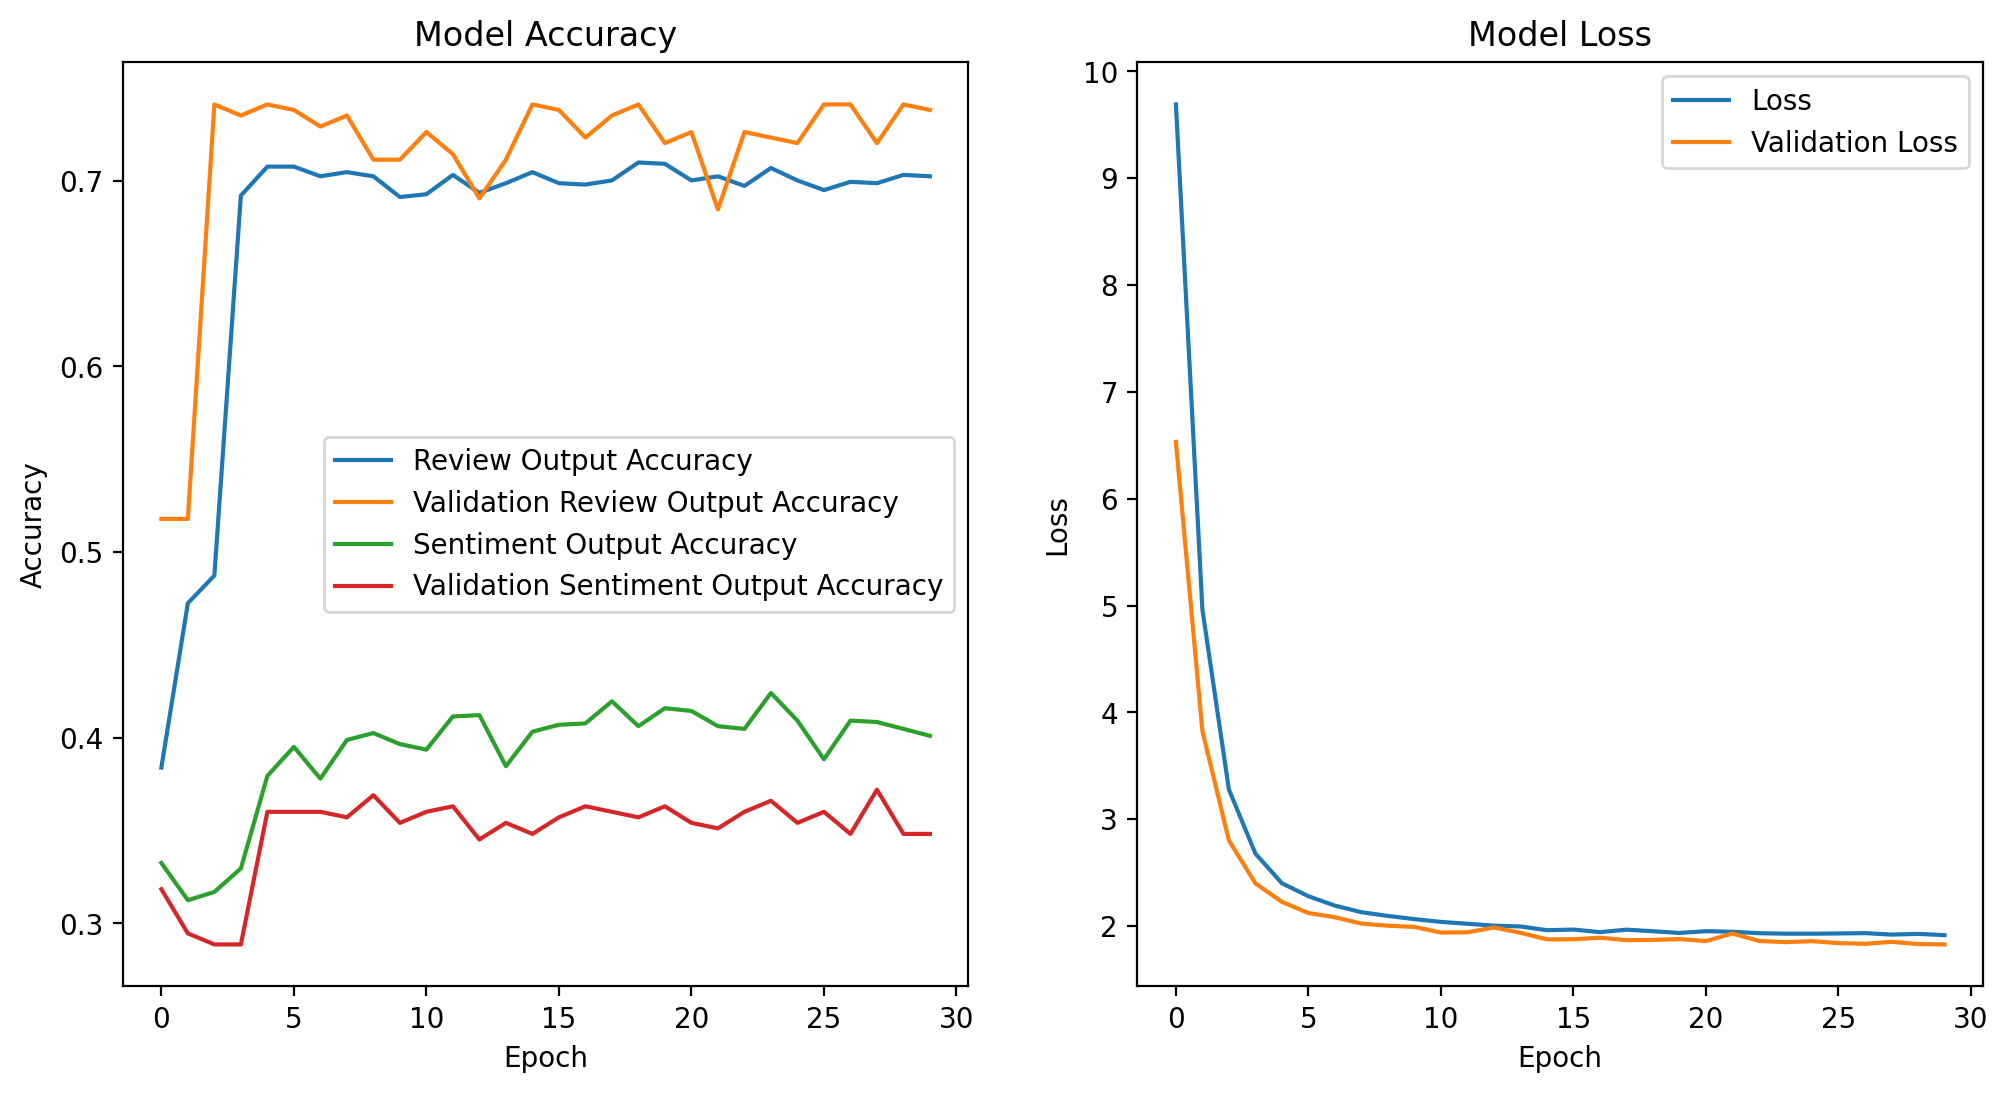

In [94]:
import matplotlib.pyplot as plt

# Plot learning curve
def plot_learning_curve(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['review_output_accuracy'], label='Review Output Accuracy')
    plt.plot(history.history['val_review_output_accuracy'], label='Validation Review Output Accuracy')
    plt.plot(history.history['sentiment_output_accuracy'], label='Sentiment Output Accuracy')
    plt.plot(history.history['val_sentiment_output_accuracy'], label='Validation Sentiment Output Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot learning curve
plot_learning_curve(history)


In [102]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Predict on the test set
y_test_pred_review = np.argmax(model.predict(X_test)[0], axis=1)
y_test_pred_sentiment = np.argmax(model.predict(X_test)[1], axis=1)

# Convert labels back to original encoding
y_test_true_review = y_test_label
y_test_true_sentiment = y_test_sentiment

14/14 [==============================] - 2s 109ms/step


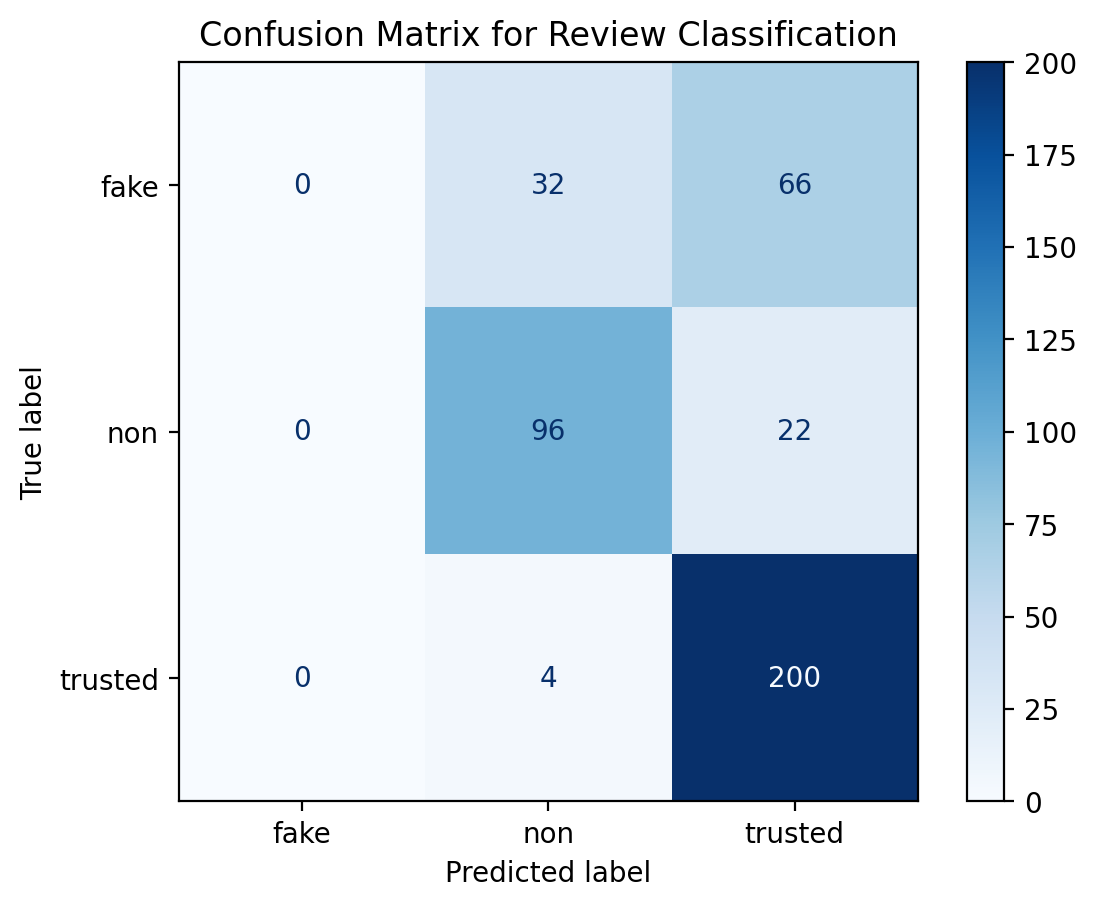

In [96]:
# Plot confusion matrix for review prediction
cm_review = confusion_matrix(y_test_true_review, y_test_pred_review)
disp_review = ConfusionMatrixDisplay(confusion_matrix=cm_review, display_labels=label_encoder_review.classes_)
disp_review.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Review Classification')
plt.show()

In [97]:
print(classification_report(y_test_true_review, y_test_pred_review, digits = 4))

print("Accuracy score: ", accuracy_score(y_test_true_review, y_test_pred_review) * 100, '%')

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        98
           1     0.7273    0.8136    0.7680       118
           2     0.6944    0.9804    0.8130       204

    accuracy                         0.7048       420
   macro avg     0.4739    0.5980    0.5270       420
weighted avg     0.5416    0.7048    0.6107       420

Accuracy score:  70.47619047619048 %


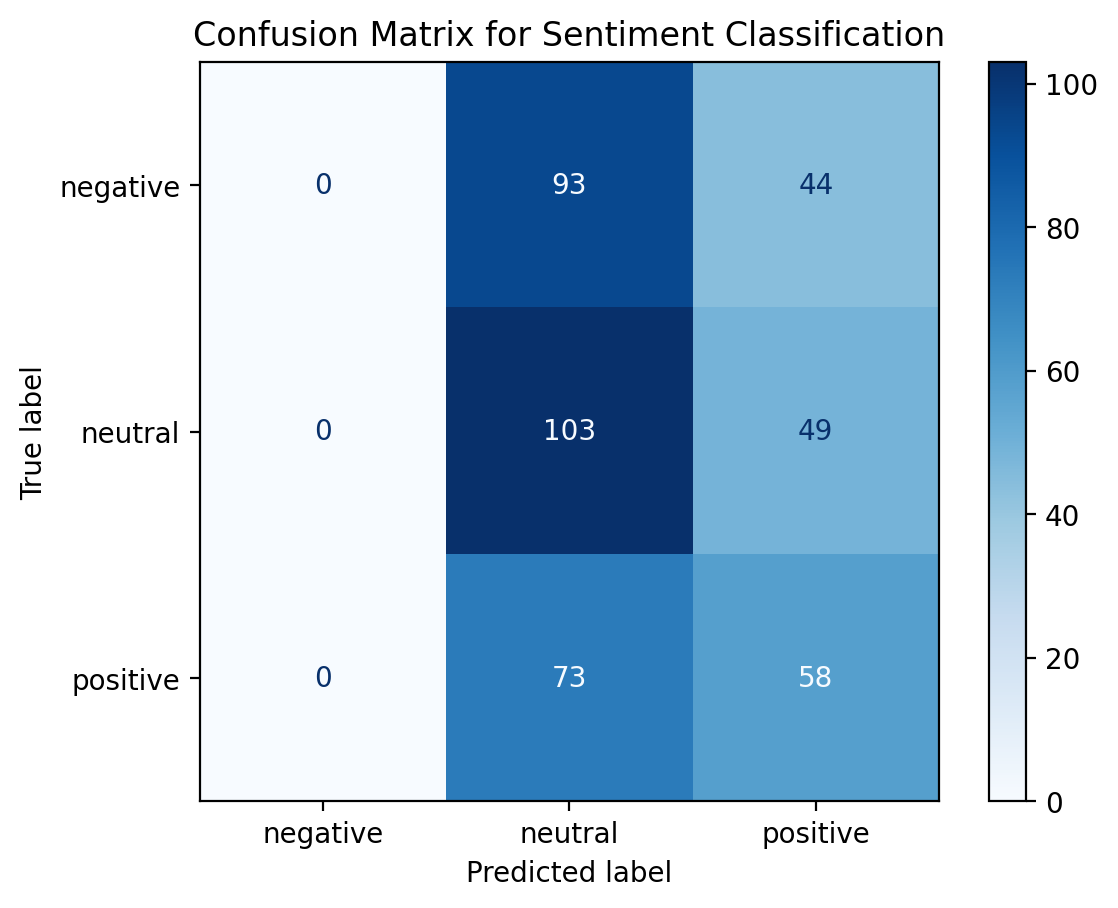

In [98]:
# Plot confusion matrix for sentiment prediction
cm_sentiment = confusion_matrix(y_test_true_sentiment, y_test_pred_sentiment)
disp_sentiment = ConfusionMatrixDisplay(confusion_matrix=cm_sentiment, display_labels=label_encoder_sentiment.classes_)
disp_sentiment.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Sentiment Classification')
plt.show()

In [99]:
print(classification_report(y_test_true_sentiment, y_test_pred_sentiment, digits = 4))

print("Accuracy score: ", accuracy_score(y_test_true_sentiment, y_test_pred_sentiment) * 100, '%')

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       137
           1     0.3829    0.6776    0.4893       152
           2     0.3841    0.4427    0.4113       131

    accuracy                         0.3833       420
   macro avg     0.2557    0.3735    0.3002       420
weighted avg     0.2584    0.3833    0.3054       420

Accuracy score:  38.333333333333336 %


In [100]:
# Function for prediction with percentage
def predict_review_with_percentage(model, tokenizer, review_text):
    sequence = tokenizer.texts_to_sequences([review_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    prediction = model.predict(padded_sequence)

    review_pred = label_encoder_review.inverse_transform(np.argmax(prediction[0], axis=1))[0]
    sentiment_pred = label_encoder_sentiment.inverse_transform(np.argmax(prediction[1], axis=1))[0]

    # Calculate percentage
    review_percentage = np.max(prediction[0]) * 100
    sentiment_percentage = np.max(prediction[1]) * 100

    return review_pred, review_percentage, sentiment_pred, sentiment_percentage



# Function to predict star rating based on sentiment percentage
def predict_star_rating(sentiment_percentage):
    if sentiment_percentage <= 20:
        return 1
    elif sentiment_percentage <= 40:
        return 2
    elif sentiment_percentage <= 60:
        return 3
    elif sentiment_percentage <= 80:
        return 4
    else:
        return 5




In [ ]:
s

In [118]:
# Example usage by user input
user_review = input("Masukkan review produk: ")
review_pred, review_percentage, sentiment_pred, sentiment_percentage = predict_review_with_percentage(model, tokenizer, user_review)

# Predict star rating based on sentiment percentage
star_rating = predict_star_rating(sentiment_percentage)
print(' ________________  Review Analysis Result ______________')
print(f'| Review : {review_pred} - Percentage: {review_percentage:.2f}%','                    |')
print(f'| Sentiment : {sentiment_pred} - Percentage: {sentiment_percentage:.2f}%','            |')
print(f'| Star Rating: {star_rating}','                                       |')
print(' -------------------------------------------------------')

Masukkan review produk: adadadaa
1/1 [==============================] - 0s 47ms/step
 ________________  Review Analysis Result ______________
| Review : non - Percentage: 66.69%                     |
| Sentiment : positive - Percentage: 44.29%             |
| Star Rating: 3                                        |
 -------------------------------------------------------
